# Ubiquant market prediction : EDA and PCA
This is a notebook dedicated to :
- analysis of the dataset of Ubiquant market prediction Kaggle competition,
- PCA on a sample of the dataset

Several ideas are picked up from this kernel https://www.kaggle.com/code/bastiendelaval/analyse-oc such as correlations and PCA.

## Librairies

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
import random

# Get files content
import os
import joblib

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import warnings

warnings.filterwarnings(action="ignore")

# scipy tools
from scipy.stats.stats import pearsonr

# sklearn tools
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    make_scorer,
)
from sklearn.model_selection import (
    learning_curve,
    cross_validate,
    KFold,
    TimeSeriesSplit,
)

# Code formatting
%load_ext nb_black

<IPython.core.display.Javascript object>

## Data importation

We use parquet version of the dataset thanks to this kernel https://www.kaggle.com/code/camilomx/parquet-format-quickstart.

In [2]:
%%time

# Import dataset
path = "./train_low_mem.parquet"
df = pd.read_parquet(path)

CPU times: user 9.55 s, sys: 3.66 s, total: 13.2 s
Wall time: 2min 45s


<IPython.core.display.Javascript object>

## First look on the dataset

In [25]:
# Display first rows
df.head(5)

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


<IPython.core.display.Javascript object>

There are 300 features named "f_i" for i in (0, 300). 

There is the target named "target".

Row_id is indexed on investment_id time_id.

For each column time_id value, there are several investment_id.

In [26]:
# Dimension
df.shape

(3141410, 304)

<IPython.core.display.Javascript object>

In [27]:
# Info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 3.6+ GB


<IPython.core.display.Javascript object>

304 columns and more than 3M of rows.

Column row_id is dtype object.

In [28]:
print("Columns of dtype uint16 : ")
for col in df.select_dtypes("uint16"):
    print(col)

Columns of dtype uint16 : 
time_id
investment_id


<IPython.core.display.Javascript object>

In [29]:
# Data summary
df.describe()

,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,...,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,6.654862e+02,1.885265e+03,-2.109159e-02,1.637057e-03,-1.257678e-02,8.514749e-03,-2.003703e-02,-5.416438e-03,-3.034008e-03,1.934330e-03,...,1.256709e-02,9.002053e-04,-6.509154e-03,2.851608e-03,-4.730820e-03,-2.773806e-02,-1.517383e-03,-7.057928e-03,-4.216896e-03,-4.319488e-03
std,3.560434e+02,1.083616e+03,9.176629e-01,1.079721e+00,1.030980e+00,1.030281e+00,9.602916e-01,9.895188e-01,1.104578e+00,1.067755e+00,...,1.084496e+00,1.114387e+00,1.070176e+00,1.101158e+00,1.144516e+00,9.592550e-01,1.140459e+00,1.108097e+00,1.051252e+00,1.008220e+00
min,0.000000e+00,0.000000e+00,-9.419646e+00,-1.765789e+01,-6.579473e+00,-8.644268e+00,-1.800427e+01,-4.000015e+00,-8.833704e+00,-6.384251e+00,...,-9.271487e+00,-6.359966e+00,-8.183732e+00,-2.399478e+01,-1.497270e+01,-9.348986e+00,-7.366648e+00,-7.579406e+00,-6.707284e+00,-1.028264e+01
25%,3.530000e+02,9.520000e+02,-5.004572e-01,-4.071441e-01,-6.813878e-01,-6.530838e-01,-4.496046e-01,-3.532303e-01,-7.070855e-01,-7.911198e-01,...,-6.037326e-01,-8.355157e-01,-6.981400e-01,-1.377131e-01,-9.397985e-01,-5.147926e-01,-9.573807e-01,-7.239380e-01,-8.165390e-01,-5.080143e-01
50%,7.040000e+02,1.882000e+03,-9.717009e-02,2.431158e-01,-4.867587e-02,4.350941e-02,-2.639937e-01,-1.908876e-01,-2.144796e-02,1.437945e-02,...,6.086323e-02,-2.023181e-01,-1.910102e-01,2.164071e-01,2.087202e-01,-2.907780e-01,6.955573e-03,-1.650222e-01,2.300689e-02,-2.824031e-01
75%,9.750000e+02,2.830000e+03,3.572908e-01,6.649507e-01,6.086557e-01,6.587324e-01,7.763371e-02,2.784694e-02,6.835684e-01,8.008306e-01,...,6.882384e-01,9.035954e-01,4.841421e-01,5.088849e-01,8.616266e-01,1.275946e-01,9.503851e-01,6.098197e-01,7.984827e-01,1.411301e-01
max,1.219000e+03,3.773000e+03,1.203861e+01,7.845261e+00,8.707207e+00,8.009340e+00,4.706333e+01,7.662866e+01,7.646200e+00,6.778142e+00,...,9.298274e+00,9.725060e+00,2.231185e+01,6.587691e+00,6.978151e+00,6.140367e+01,7.679950e+00,1.241804e+01,7.003982e+00,4.337021e+01


<IPython.core.display.Javascript object>

Features seem to have low values (< 100) and can get be negative, even for the target.

As the means are very close to zero, we can consider that features f had already been standardized.

In [30]:
# Check if there are missing values
df.isnull().sum().sum()

0

<IPython.core.display.Javascript object>

There is no missing value.

### Reduce memory usage of the dataset
Many kernels use this function to reduce the memory usage of the dataset (to avoid Memory-over error). I didn't find the original kernel that introduce this.

Be careful it takes a long time.

EDIT : it seems that there is a lost of information, especially when we get the describe information. I am not sure if it is a good idea.

I wrote a notebook about it https://www.kaggle.com/code/larochemf/ubiquant-low-memory-use-be-careful. It seems that some lines have to be changed. Nevertheless, I finally did not use this function.

In [3]:
%%time

def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024 ** 2

    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


df_1 = reduce_mem_usage(df)

Memory usage of dataframe is 3642.99 MB
Memory usage after optimization is: 1915.96 MB
Decreased by 47.4%
CPU times: user 3min 10s, sys: 2min 39s, total: 5min 49s
Wall time: 5min 51s


<IPython.core.display.Javascript object>

In [23]:
# Data summary
df_1.describe()

,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3141410.0,3141410.0,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,...,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,NaN,NaN,NaN,1.633644e-03,-1.258850e-02,8.499146e-03,-1.992798e-02,-5.428314e-03,-3.021240e-03,1.940727e-03,...,1.258850e-02,8.964539e-04,-6.500244e-03,2.836227e-03,-4.730225e-03,NaN,-1.508713e-03,-7.053375e-03,-4.215240e-03,-4.329681e-03
std,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,0.0,0.0,-9.421875e+00,-1.765625e+01,-6.578125e+00,-8.640625e+00,-1.800000e+01,-4.000000e+00,-8.835938e+00,-6.382812e+00,...,-9.273438e+00,-6.359375e+00,-8.187500e+00,-2.400000e+01,-1.497656e+01,-9.351562e+00,-7.367188e+00,-7.578125e+00,-6.707031e+00,-1.028125e+01
25%,353.0,952.0,-5.004883e-01,-4.072266e-01,-6.811523e-01,-6.533203e-01,-4.497070e-01,-3.532715e-01,-7.070312e-01,-7.910156e-01,...,-6.035156e-01,-8.354492e-01,-6.982422e-01,-1.376953e-01,-9.399414e-01,-5.146484e-01,-9.575195e-01,-7.241211e-01,-8.164062e-01,-5.078125e-01
50%,704.0,1882.0,-9.716797e-02,2.431641e-01,-4.867554e-02,4.351807e-02,-2.639160e-01,-1.909180e-01,-2.145386e-02,1.438141e-02,...,6.085205e-02,-2.022705e-01,-1.910400e-01,2.164307e-01,2.087402e-01,-2.907715e-01,6.954193e-03,-1.650391e-01,2.301025e-02,-2.824707e-01
75%,975.0,2830.0,3.571777e-01,6.650391e-01,6.088867e-01,6.586914e-01,7.763672e-02,2.784729e-02,6.835938e-01,8.007812e-01,...,6.884766e-01,9.038086e-01,4.841309e-01,5.087891e-01,8.618164e-01,1.275635e-01,9.501953e-01,6.098633e-01,7.983398e-01,1.411133e-01
max,1219.0,3772.0,1.203906e+01,7.843750e+00,8.710938e+00,8.007812e+00,4.706250e+01,7.662500e+01,7.644531e+00,6.777344e+00,...,9.296875e+00,9.726562e+00,2.231250e+01,6.585938e+00,6.976562e+00,6.140625e+01,7.679688e+00,1.242188e+01,7.003906e+00,4.337500e+01


<IPython.core.display.Javascript object>

## Features analysis

We are going to analyse features, with some points taken from this kernel https://www.kaggle.com/code/jiahauc/ubiqunt-eda-linearregression
### Investment

In [31]:
investments = df["investment_id"].nunique()
print("Number of unique investiment_id : ", investments)

Number of unique investiment_id :  3579


<IPython.core.display.Javascript object>

In [32]:
df["investment_id"].value_counts()

2140    1211
2385    1209
1062    1209
1144    1209
2727    1209
        ... 
905        8
2558       8
3662       7
2800       3
1415       2
Name: investment_id, Length: 3579, dtype: int64

<IPython.core.display.Javascript object>

It seems that several investments have low frequency. Let's have a look at investment_id = 905.

In [33]:
df.loc[df["investment_id"] == 905]

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
3114764,1212_905,1212,905,0.000000,-0.252274,1.872387,0.0,4.923997,0.670442,-0.845651,...,-0.311686,-0.770785,5.261123,0.484249,1.284623,5.690303,0.902837,-0.551608,0.000000,-0.747439
3118203,1213_905,1213,905,0.000000,0.493875,1.320280,0.0,3.733451,0.778219,1.180876,...,-0.295776,-0.635073,4.657701,1.114632,0.785815,5.434180,0.859254,-0.394131,0.000000,-0.744025
3121643,1214_905,1214,905,2.146115,0.550417,0.807305,0.0,3.269549,0.757987,1.683211,...,-0.274161,-0.718450,2.626396,0.920422,-0.713328,3.415019,1.051396,-0.597937,0.000000,5.406450
3125082,1215_905,1215,905,-1.416078,0.559272,0.318800,0.0,3.273175,0.761414,1.991194,...,-0.979614,-0.694756,-0.071421,0.769126,0.966756,2.679727,1.138049,-0.651654,0.000000,5.052356
3128514,1216_905,1216,905,1.967065,0.782685,-0.057016,0.0,3.911410,0.814832,2.456574,...,-0.241323,-0.730822,0.745772,-1.161238,0.858016,2.376080,0.944268,-0.917331,2.228480,5.241991
3131924,1217_905,1217,905,1.357834,0.672741,-0.451416,0.0,3.066842,0.751619,1.683241,...,-0.221902,-1.651239,0.945587,0.405561,-1.481123,1.855866,0.611560,-0.768422,2.030847,5.096809
3135350,1218_905,1218,905,-1.402726,0.289558,-0.486492,0.0,3.389831,0.797012,-1.569283,...,0.102714,1.220921,0.463999,0.482149,-1.033200,2.159562,1.132108,1.376168,1.838660,5.095539
3138783,1219_905,1219,905,-3.046411,0.482918,-0.330059,0.0,3.816887,0.826104,-1.804322,...,-0.818708,0.811402,-0.613150,-1.142157,0.421628,2.611042,1.363181,4.093065,1.701075,4.794515


<IPython.core.display.Javascript object>

This investment is only present at this end of the dataset.

In [34]:
# Get list of number investment_id appearing less than 5, 10.. until 100 times
list_invest = []

for i in range(5, 101, 5):
    list_invest.append((df["investment_id"].value_counts() < i).sum())

<IPython.core.display.Javascript object>

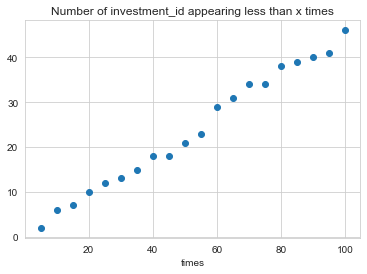

<IPython.core.display.Javascript object>

In [35]:
# Plot the result
plt.scatter(range(5, 101, 5), list_invest)
plt.title("Number of investment_id appearing less than x times")
plt.xlabel("times")
plt.show()

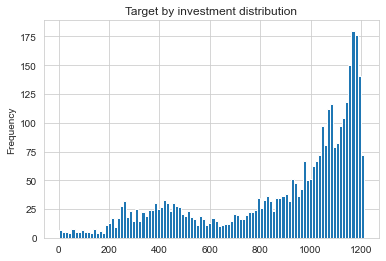

<IPython.core.display.Javascript object>

In [36]:
# Let's group by investment_id and see distribution
obs_by_investments = df.groupby(["investment_id"])["target"].count()

obs_by_investments.plot(kind="hist", bins=100)
plt.title("Target by investment distribution")
plt.show()

There are more targets with investment_id with high values count.

In [38]:
# Get mean values of the target when groupping by investment_id
mean_targets = df.groupby(["investment_id"])["target"].mean()
mean_targets

investment_id
0       0.052841
1      -0.025687
2      -0.051106
3       0.046773
4      -0.047773
          ...   
3768   -0.027151
3769   -0.028946
3770   -0.073020
3772   -0.013986
3773   -0.015845
Name: target, Length: 3579, dtype: float32

<IPython.core.display.Javascript object>

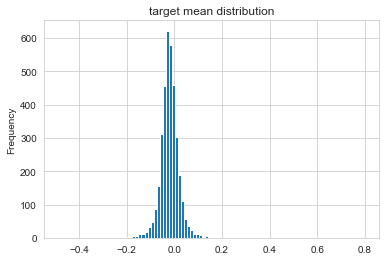

<IPython.core.display.Javascript object>

In [39]:
# Plot these means distributions
mean_targets.plot(kind="hist", bins=100)
plt.title("target mean distribution")
plt.show()

Target mean distribution is close to normal distribution.

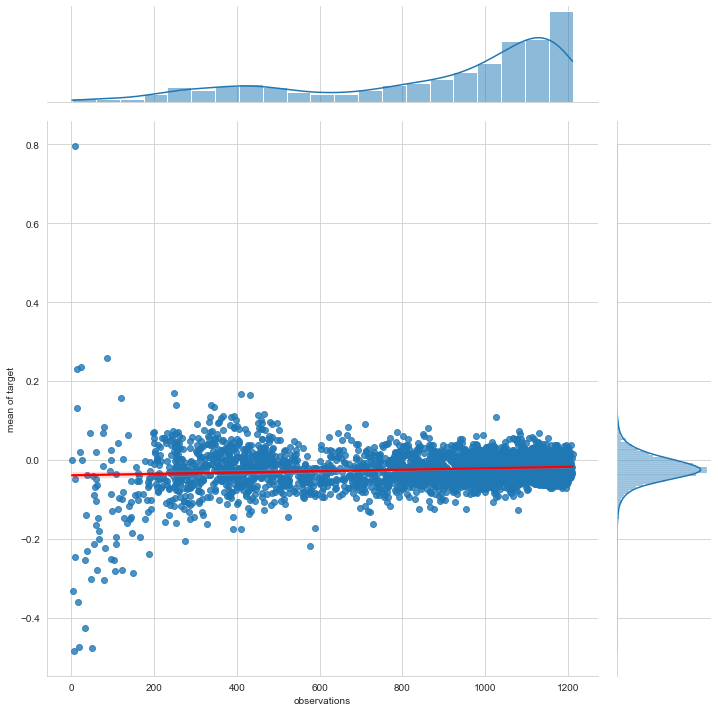

<IPython.core.display.Javascript object>

In [40]:
ax = sns.jointplot(
    x=obs_by_investments,
    y=mean_targets,
    kind="reg",
    height=10,
    joint_kws={"line_kws": {"color": "red"}},
)
ax.ax_joint.set_xlabel("observations")
ax.ax_joint.set_ylabel("mean of target")
plt.show()

Through this joint plot of observations in each investment and mean target value in each investment, it shows there is a growing trend when the observations increase. Also, the dispersion of target values is more apparent when the number of recorded investments is relatively low.

### time_id

In [41]:
timestamps = df["time_id"].nunique()
print("Number of unique time_id : ", timestamps)

Number of unique time_id :  1211


<IPython.core.display.Javascript object>

In [42]:
df["time_id"].value_counts()

1214    3445
1209    3444
1211    3440
1207    3440
1208    3438
        ... 
415      659
362      651
374      600
398      539
492      512
Name: time_id, Length: 1211, dtype: int64

<IPython.core.display.Javascript object>

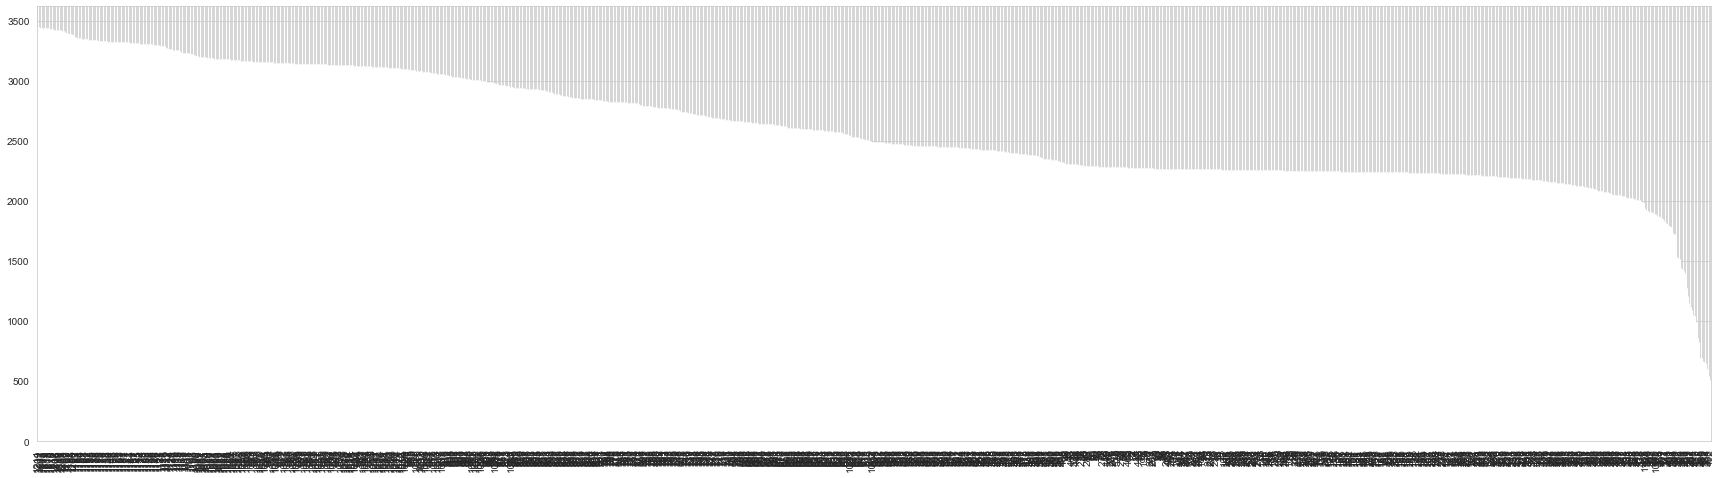

<IPython.core.display.Javascript object>

In [43]:
plt.figure(figsize=(30, 8))
df["time_id"].value_counts().plot(kind="bar")
plt.show()

In [44]:
print(
    "Percent of time_id value_counts >= 2000 : {}%".format(
        round(
            (df["time_id"].value_counts() >= 2000).sum()
            / len(df["time_id"].value_counts())
            * 100,
            1,
        )
    )
)

Percent of time_id value_counts >= 2000 : 95.8%


<IPython.core.display.Javascript object>

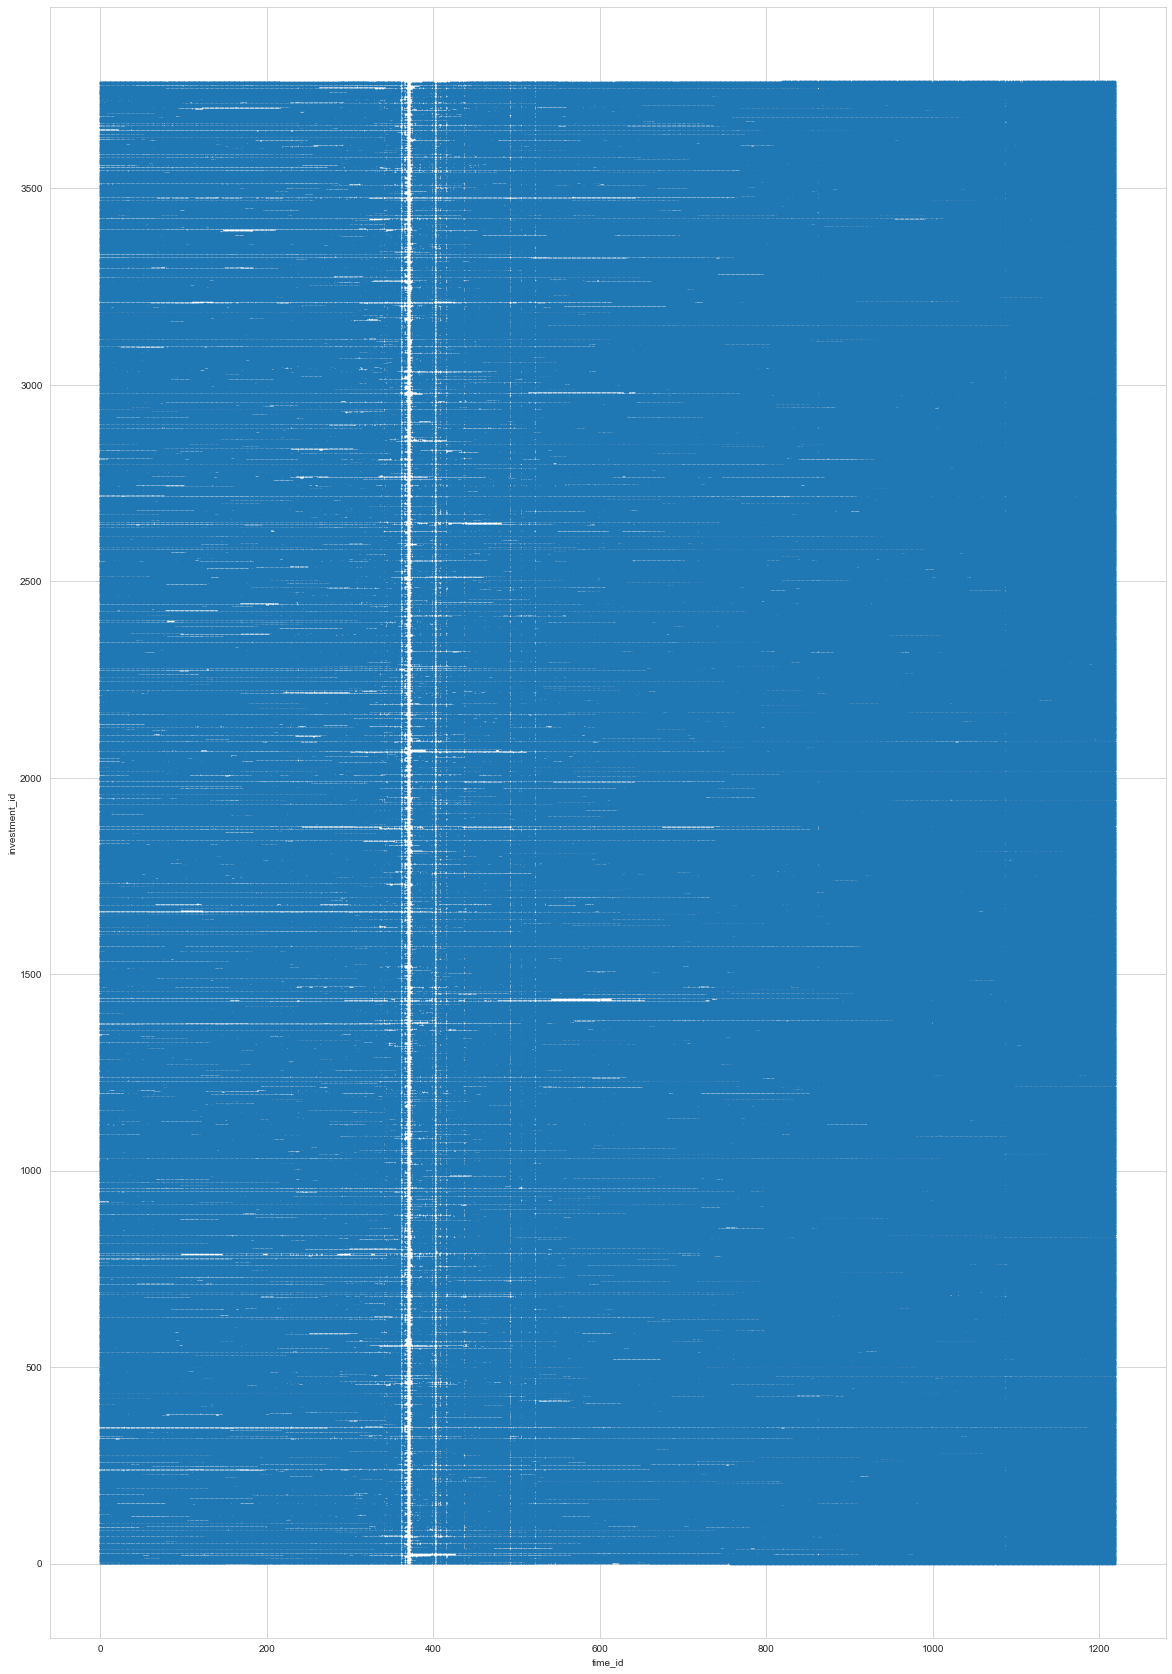

<IPython.core.display.Javascript object>

In [45]:
# Let's plot investment_id and time_id together
df[["time_id", "investment_id"]].plot(
    kind="scatter", x="time_id", y="investment_id", figsize=(20, 30), s=0.5
)
plt.show()

We can see that investment_id are more present with high time_id.

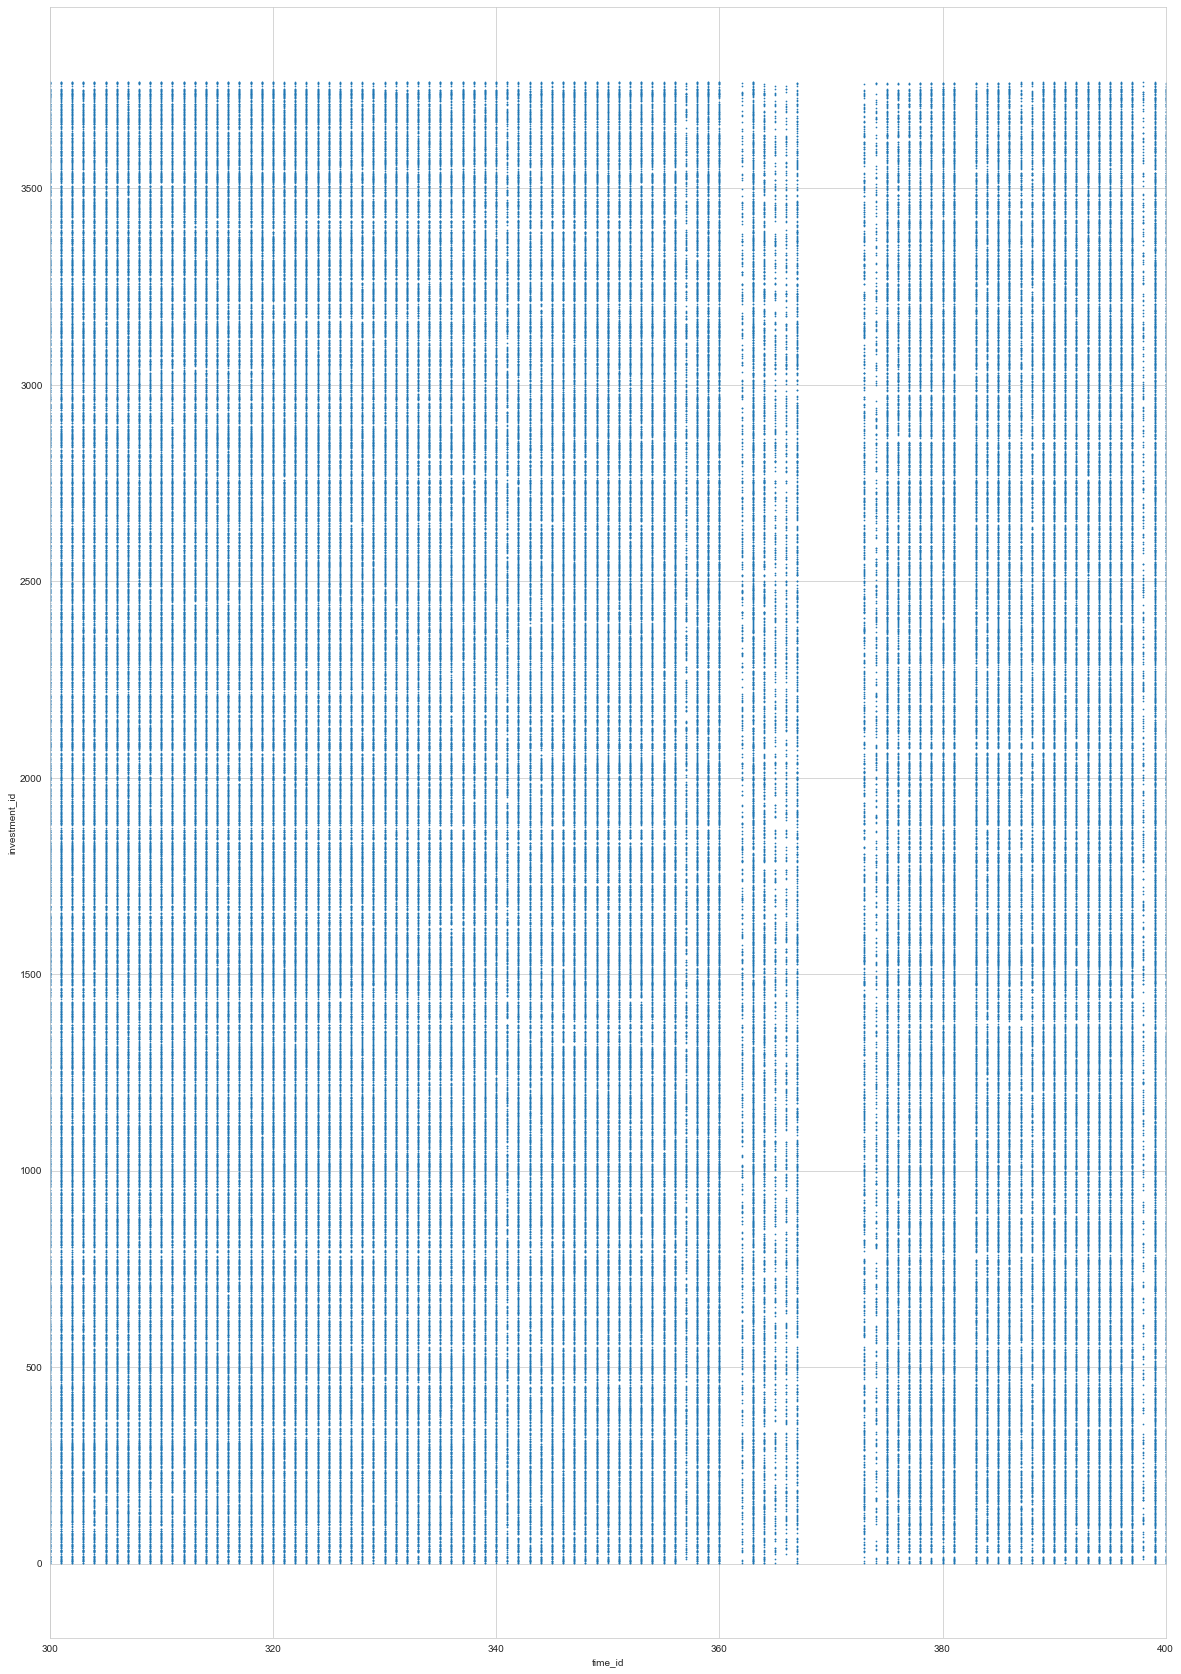

<IPython.core.display.Javascript object>

In [46]:
# Let's see what's happenning around 300-400 time_id.
df[["time_id", "investment_id"]].plot(
    kind="scatter", x="time_id", y="investment_id", figsize=(20, 30), s=0.5
)
plt.xlim(300, 400)
plt.show()

We can see that there are some missing time_id.

### Features f_i
A histogram of all features is available at this kernel https://www.kaggle.com/code/mk1001/eda-f-0-299-histogram/notebook.

Let's see randomly six of them with boxplot :

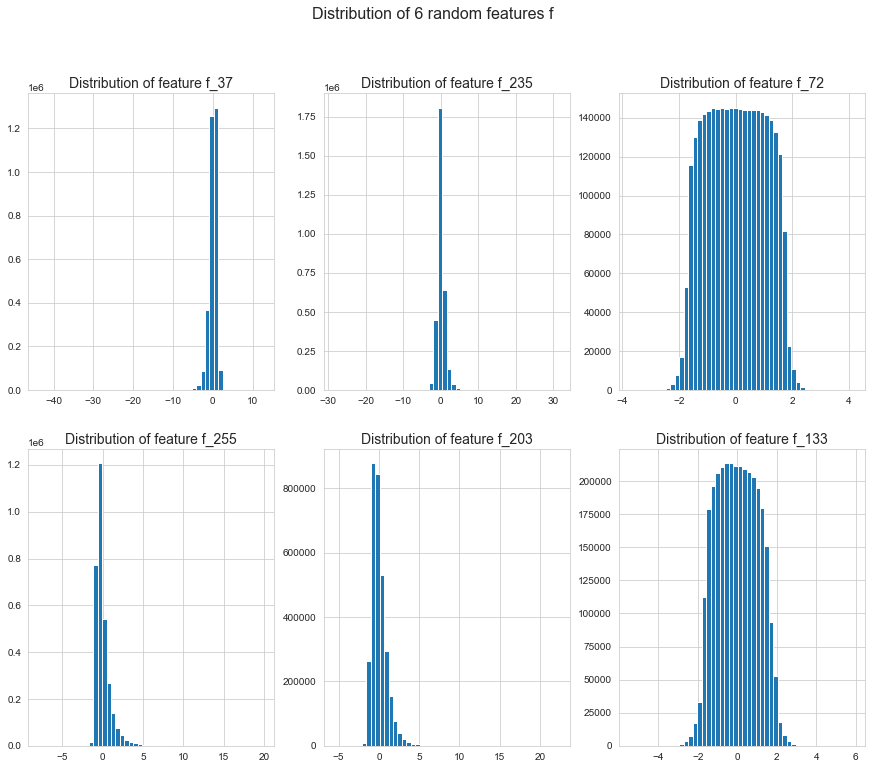

<IPython.core.display.Javascript object>

In [47]:
np.random.seed(1)

# Initiate counter
i = 1

# Initiate plot
plt.figure(figsize=(15, 12))
plt.suptitle("Distribution of 6 random features f", size=16)

# Plot randomly 6 histograms of features f_
for f in np.random.choice(range(0, 300), 6):
    plt.subplot(2, 3, i)
    df["f_{}".format(f)].hist(bins=50)
    plt.title("Distribution of feature f_{}".format(f), size=14)
    i += 1

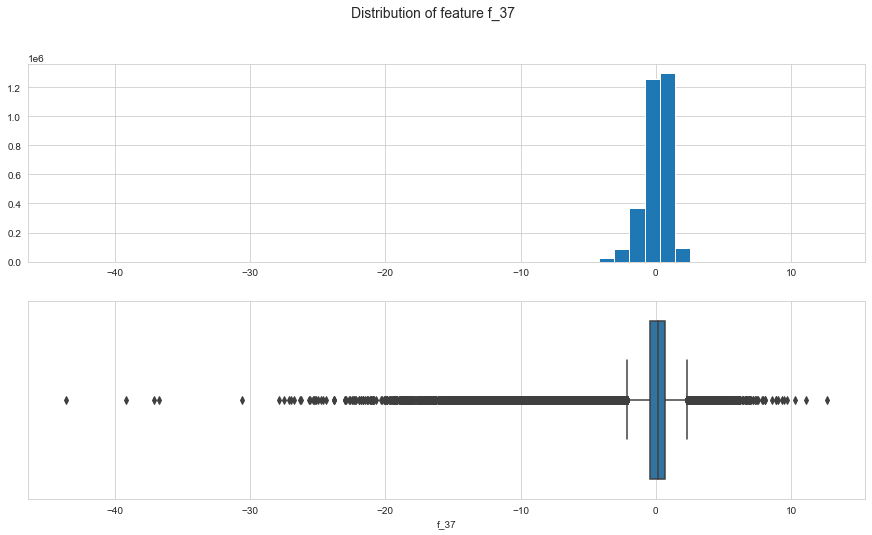

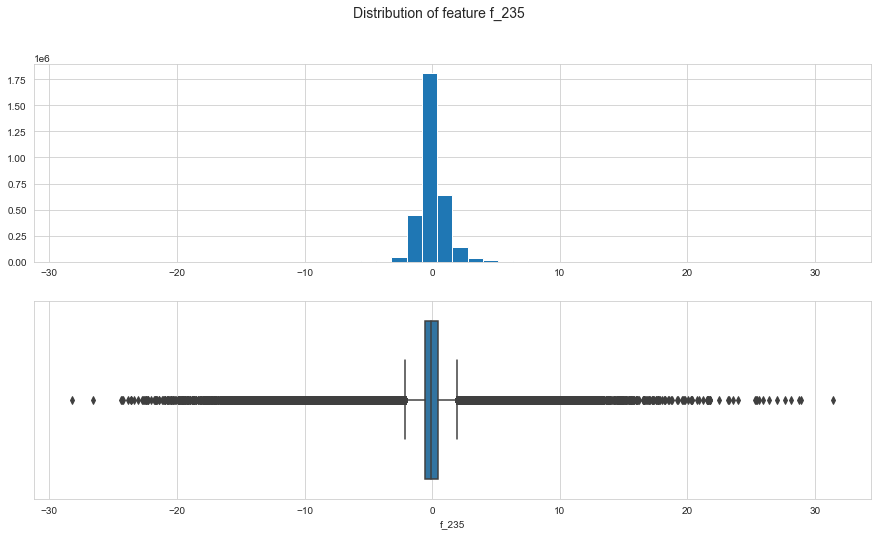

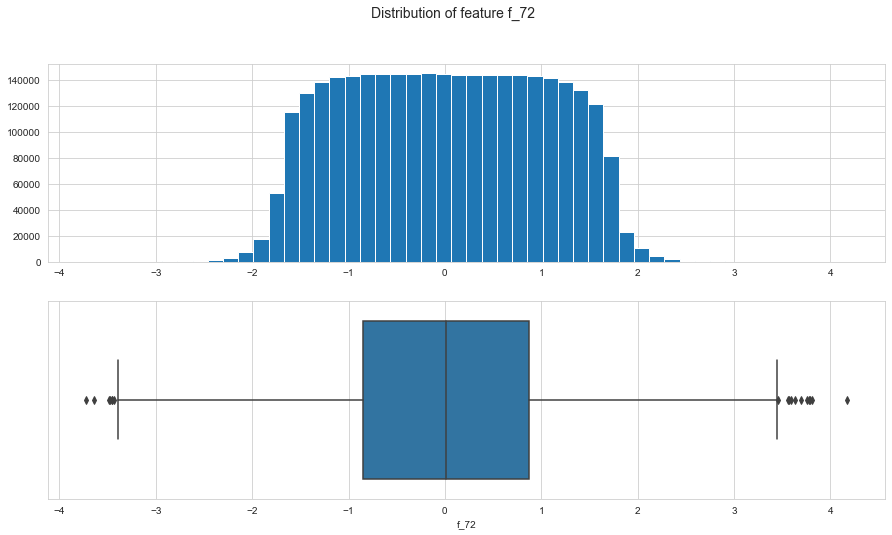

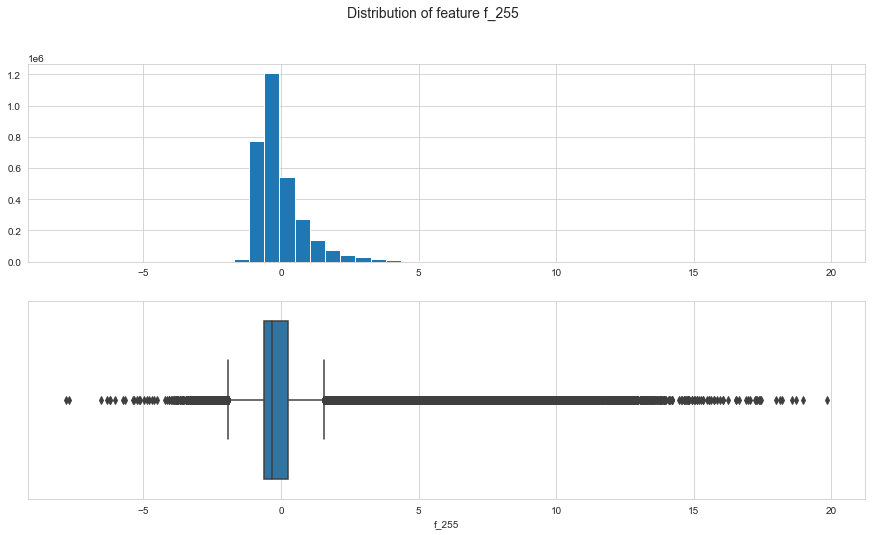

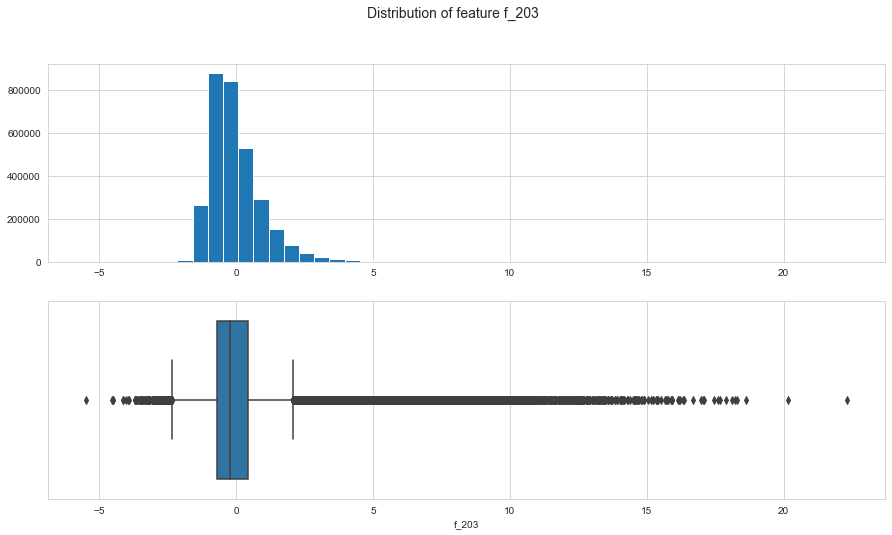

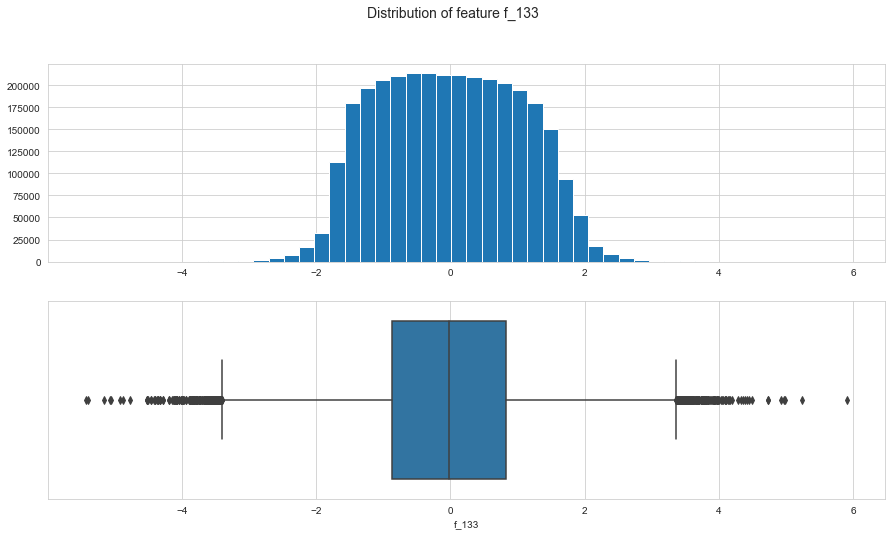

<IPython.core.display.Javascript object>

In [3]:
np.random.seed(1)

# Plot randomly 6 histograms and boxplots of features f_
for f in np.random.choice(range(0, 300), 6):
    
    # Initiate plot
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    plt.suptitle("Distribution of feature f_{}".format(f), size=14)
    
    # Target histogram
    df["f_{}".format(f)].hist(bins=50, ax=axes[0])

    # Target Boxplot
    sns.boxplot(x="f_{}".format(f), data=df, ax=axes[1])
    plt.show()

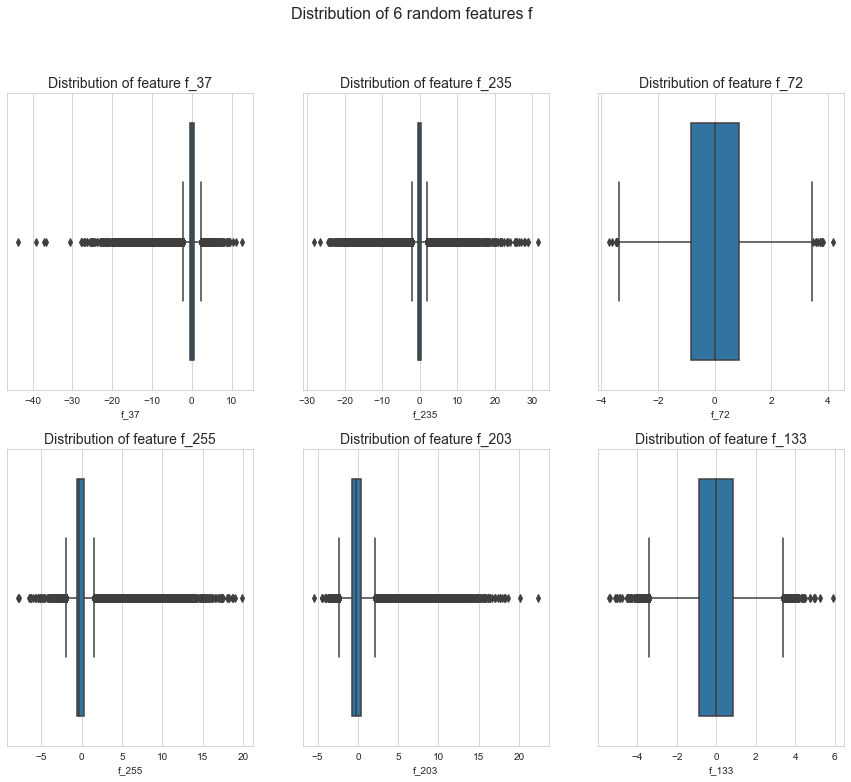

<IPython.core.display.Javascript object>

In [122]:
np.random.seed(1)

# Initiate counter
i = 1

# Initiate plot
plt.figure(figsize=(15, 12))
plt.suptitle("Distribution of 6 random features f", size=16)

# Plot randomly 6 histograms of features f_
for f in np.random.choice(range(0, 300), 6):
    plt.subplot(2, 3, i)
    sns.boxplot(x="f_{}".format(f), data=df)
    plt.title("Distribution of feature f_{}".format(f), size=14)
    i += 1

Some features are centered in zero.

Some of them get outliers as the distribution is not centered. So maybe, in the future we could consider to normalize data with a Robust Scaler in order to limit the influence of outliers.

In [4]:
# List of features columns
features = [f"f_{i}" for i in range(0, 300)]

<IPython.core.display.Javascript object>

### Target
Let's see the target distribution.

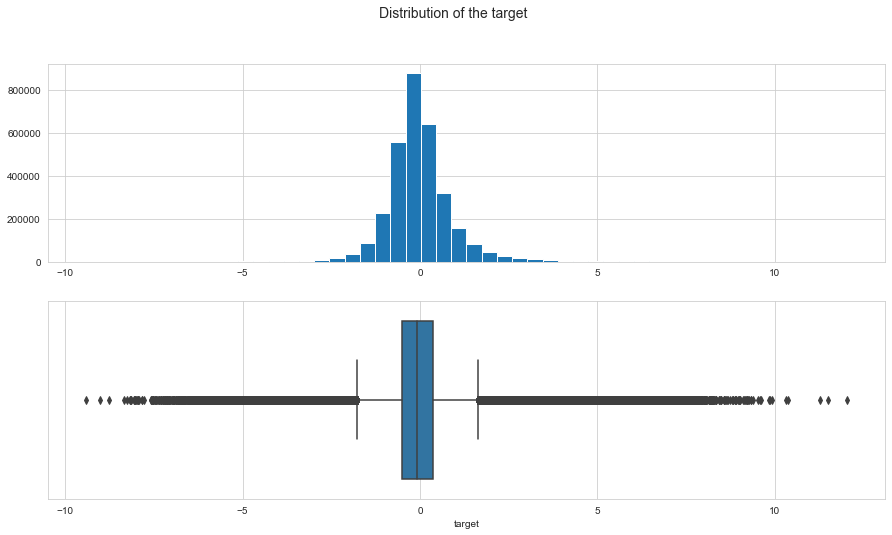

<IPython.core.display.Javascript object>

In [50]:
# Initiate plot
f, axes = plt.subplots(2, 1, figsize=(15, 8))

plt.suptitle("Distribution of the target", size=14)

# Target histogram
df["target"].hist(bins=50, ax=axes[0])

# Target Boxplot
sns.boxplot(x="target", data=df, ax=axes[1])
plt.show()

In [51]:
mean_target = df["target"].mean()
std_target = df["target"].std()
print("Target mean value : ", mean_target)
print("Target std value : ", std_target)

Target mean value :  -0.021091585978865623
Target std value :  0.9176628589630127


<IPython.core.display.Javascript object>

The distribution seems to be gaussian.

Let's plot the target distribution for some investment_id :

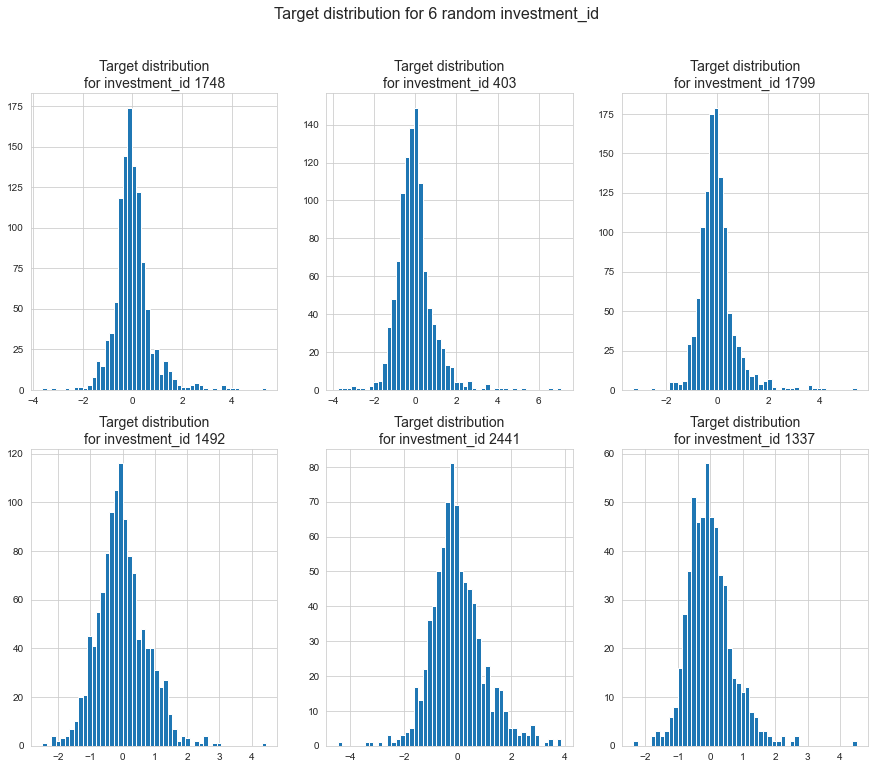

<IPython.core.display.Javascript object>

In [52]:
np.random.seed(1)

# Initiate counter
i = 1

# Initiate plot
plt.figure(figsize=(15, 12))
plt.suptitle("Target distribution for 6 random investment_id", size=16)

# Plot randomly 6 histograms of the target
for j in np.random.choice(df["investment_id"].unique(), 6):
    plt.subplot(2, 3, i)
    df[df["investment_id"] == j]["target"].hist(bins=50)
    plt.title("Target distribution\nfor investment_id {}".format(j), size=14)
    i += 1

For individual investment_id, target distribution seems to be less gaussian. Some values are high for values being at the "tail of the distribution" (e.g. investment_id 2441, 1337).

## Bidimensional analysis
### Get a sample dataset
Let's take a sample of the data.

In [53]:
sample_df = df.sample(frac=0.05, random_state=1)
sample_df

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
607231,270_482,270,482,1.393967,0.563777,0.329479,-1.315388,1.401520,0.016631,1.121079,...,0.847788,-0.819923,0.835474,0.319715,0.555386,0.556217,1.071587,-0.586470,-0.411992,0.412774
1435447,653_1885,653,1885,0.444124,-0.293736,0.655731,2.352335,0.026236,-0.572945,-0.872195,...,0.014079,-0.768240,-0.457168,0.472227,0.968007,-0.637575,-1.078555,-1.184083,-0.522147,-0.691200
1719449,759_3490,759,3490,0.280826,0.164325,0.872954,0.018527,-0.321309,-0.169804,-1.195469,...,-0.117692,1.045337,-0.246952,0.198558,-1.068690,-0.164562,-0.910962,0.178173,-0.027948,-0.385263
2166750,914_2149,914,2149,1.096577,0.941188,0.873456,-1.988921,2.852207,0.489025,1.074427,...,-1.242727,-1.019845,3.756444,0.844376,-1.028926,2.516795,1.265585,0.255740,0.758226,-0.830256
399169,176_3484,176,3484,-0.114734,0.869987,0.410584,1.002557,-0.255925,-0.539050,-1.188686,...,-0.753905,-0.516182,0.544362,0.150008,2.002837,-0.556329,-1.540250,0.551607,0.379718,-0.778006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248400,940_3636,940,3636,0.008491,0.935135,-1.455870,1.542440,-0.427455,-0.289459,-0.174019,...,-0.033160,0.862841,-0.355079,0.319239,1.099015,-0.516841,1.039523,-0.499201,1.388868,-0.535364
778810,350_919,350,919,-0.376004,-1.357517,-0.255878,0.837919,-1.442843,-0.489968,0.982652,...,-0.508619,-0.750760,-1.238941,0.099460,-1.539896,-0.880276,0.082330,-0.852978,1.616588,-0.303441
258031,113_3187,113,3187,-0.271133,0.714163,1.133366,0.130781,-0.394935,-0.343455,-0.903826,...,-0.381002,-0.588363,0.042733,0.385851,-0.609556,-0.363498,-0.129711,-0.550309,0.962057,-0.769098
2866111,1137_1967,1137,1967,-0.059472,-1.662638,0.263819,-0.863438,-0.418975,-0.195200,1.982726,...,0.107851,1.127201,-0.318118,1.135920,1.022511,-0.328731,1.280213,0.640524,0.185460,-0.297201


<IPython.core.display.Javascript object>

In [83]:
# Sort by time_id and investment_id to get data in order 
# and reset index
sample_df = sample_df.sort_values(
    ["time_id", "investment_id"], ascending=[True, True]
).reset_index(drop=True)
sample_df

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_19,0,19,0.685847,0.025283,-0.011870,-0.390564,-0.600695,-0.218549,1.253159,...,0.333684,0.912726,-0.122073,0.819155,-1.060166,-0.169155,0.104928,0.404938,-0.261311,-0.050004
1,0_98,0,98,0.586187,0.677165,-0.011870,-0.523899,0.419864,-0.114329,1.740953,...,-1.146118,0.912726,0.669720,0.819155,0.941183,-0.128453,1.296864,1.315424,-0.944005,-0.220631
2,0_173,0,173,1.076665,0.353120,0.615937,-0.082875,0.778190,0.159433,1.843599,...,0.366028,0.912726,1.797567,0.819155,-1.060166,0.884854,-1.087009,-1.365066,-1.132301,0.185581
3,0_315,0,315,1.121235,0.861542,1.494866,-0.089574,1.295896,0.006026,0.402792,...,-1.146118,0.912726,3.382770,0.819155,-1.060166,0.007830,-1.087009,0.297326,-1.429945,0.683604
4,0_335,0,335,3.161701,0.736542,0.113691,-1.845710,3.024322,-0.074793,1.738294,...,-0.609724,-1.095620,1.809639,-1.220772,-1.060166,0.267981,1.296864,-1.518155,0.887500,0.814394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157065,1219_3617,1219,3617,-1.081809,-0.015136,1.360878,1.454888,-0.448471,0.706850,-1.978520,...,0.137736,0.811402,0.138719,0.875537,0.421628,2.438486,1.363181,0.802745,1.019560,2.740571
157066,1219_3624,1219,3624,-1.027750,-0.685306,-0.720275,1.109542,-0.442211,-0.095155,0.119591,...,1.125366,0.811402,-0.477710,-1.142157,0.421628,-0.163245,-0.075548,0.166830,0.020751,-0.040690
157067,1219_3679,1219,3679,1.321338,0.688519,-0.590203,1.097954,-0.457912,-0.101383,0.555881,...,3.007065,0.811402,1.206952,-1.142157,0.421628,-0.334677,-1.514277,0.016244,0.097308,-0.155512
157068,1219_3759,1219,3759,-0.059480,0.498102,0.840589,0.310822,0.141530,0.500877,0.015716,...,-0.301501,0.811402,-0.282957,-1.142157,0.421628,1.311420,-1.514277,-0.808533,-1.034686,0.726296


<IPython.core.display.Javascript object>

In [84]:
# Save this dataset to csv
sample_df.to_csv("./sample_df.csv")

<IPython.core.display.Javascript object>

In [2]:
# Dictionnary of columns dtypes when reloading csv
data_types_dict = {
    "row_id": "object",
    "time_id": "uint16",
    "investment_id": "uint16",
    "target": "float32",
}

features = [f"f_{i}" for i in range(300)]

for f in features:
    data_types_dict[f] = "float32"

target = "target"

<IPython.core.display.Javascript object>

In [3]:
# Reload csv
sample_df = pd.read_csv(
    "./sample_df.csv",
    usecols=data_types_dict.keys(),
    dtype=data_types_dict,
    # index_col=0,
)
sample_df

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_19,0,19,0.685847,0.025283,-0.011870,-0.390564,-0.600695,-0.218549,1.253159,...,0.333684,0.912726,-0.122073,0.819155,-1.060166,-0.169155,0.104928,0.404938,-0.261311,-0.050004
1,0_98,0,98,0.586187,0.677165,-0.011870,-0.523899,0.419864,-0.114329,1.740953,...,-1.146118,0.912726,0.669720,0.819155,0.941183,-0.128453,1.296864,1.315424,-0.944005,-0.220631
2,0_173,0,173,1.076665,0.353120,0.615937,-0.082875,0.778190,0.159433,1.843599,...,0.366028,0.912726,1.797567,0.819155,-1.060166,0.884854,-1.087009,-1.365066,-1.132301,0.185581
3,0_315,0,315,1.121235,0.861542,1.494866,-0.089574,1.295896,0.006026,0.402792,...,-1.146118,0.912726,3.382770,0.819155,-1.060166,0.007830,-1.087009,0.297326,-1.429945,0.683604
4,0_335,0,335,3.161701,0.736542,0.113691,-1.845710,3.024322,-0.074793,1.738294,...,-0.609724,-1.095620,1.809639,-1.220772,-1.060166,0.267981,1.296864,-1.518155,0.887500,0.814394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157065,1219_3617,1219,3617,-1.081809,-0.015136,1.360878,1.454888,-0.448471,0.706850,-1.978520,...,0.137736,0.811402,0.138719,0.875537,0.421628,2.438486,1.363181,0.802745,1.019560,2.740571
157066,1219_3624,1219,3624,-1.027750,-0.685306,-0.720275,1.109542,-0.442211,-0.095155,0.119591,...,1.125366,0.811402,-0.477710,-1.142157,0.421628,-0.163245,-0.075548,0.166830,0.020751,-0.040690
157067,1219_3679,1219,3679,1.321338,0.688519,-0.590203,1.097954,-0.457912,-0.101383,0.555881,...,3.007065,0.811402,1.206952,-1.142157,0.421628,-0.334677,-1.514277,0.016244,0.097308,-0.155512
157068,1219_3759,1219,3759,-0.059480,0.498102,0.840589,0.310822,0.141530,0.500877,0.015716,...,-0.301501,0.811402,-0.282957,-1.142157,0.421628,1.311420,-1.514277,-0.808533,-1.034686,0.726296


<IPython.core.display.Javascript object>

In [4]:
# Dataframe information
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157070 entries, 0 to 157069
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 182.1+ MB


<IPython.core.display.Javascript object>

Check the target distribution

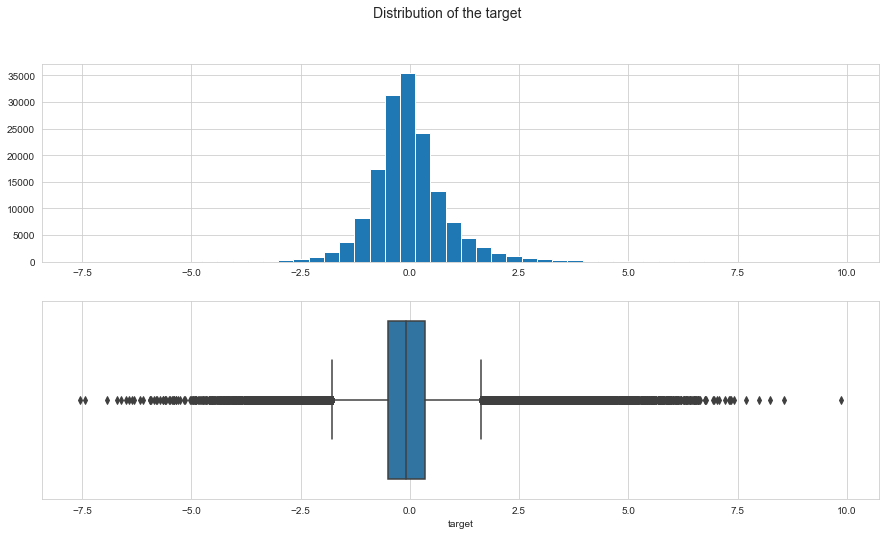

<IPython.core.display.Javascript object>

In [86]:
# Initiate plot
f, axes = plt.subplots(2, 1, figsize=(15, 8))

plt.suptitle("Distribution of the target", size=14)

# Target histogram
sample_df["target"].hist(bins=50, ax=axes[0])

# Target Boxplot
sns.boxplot(x="target", data=sample_df, ax=axes[1])
plt.show()

Distribution is close to the one in the full dataset, but we don't have outliers above 10 and less than 8 as there are in the full dataset.


### Correlation
#### Target vs features
Let's see if the target is correlated to the features f_i.

In [87]:
correlation = sample_df[["target"] + features].corr()

<IPython.core.display.Javascript object>

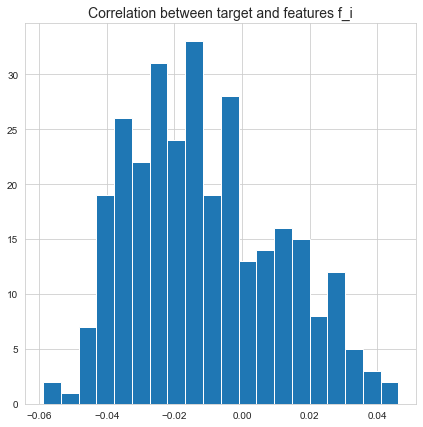

<IPython.core.display.Javascript object>

In [88]:
# Plot correlation values between target and features f_i
plt.figure(figsize=(7, 7))
correlation["target"].iloc[1:].hist(bins=20)
plt.title("Correlation between target and features f_i", size=14)
plt.show()

Correlation values are very low, so it means that target is not linked to features.
#### Between features
Let's see the correlation between the features f_i. As there are 300 features, it is difficult to see all correlations.

In [5]:
def mat_corr(df):
    """
    Function to plot correlation matrix heatmap between columns of a dataframe
    
    Arguments :
    - dataframe df
    
    Display :
    - correlation matrix as heatmap
    """

    # Compute correlation
    corr = df.corr()

    # Mask to display only lower part of the heatmap
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Plot initialization
    f, ax = plt.subplots(figsize=(30, 30))

    # Color mapping
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Heatmap
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        # vmax=1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar=True,
        # annot=True, # do not display correlation values
    )
    plt.title("Correlation Matrix", size=20)
    plt.show()

<IPython.core.display.Javascript object>

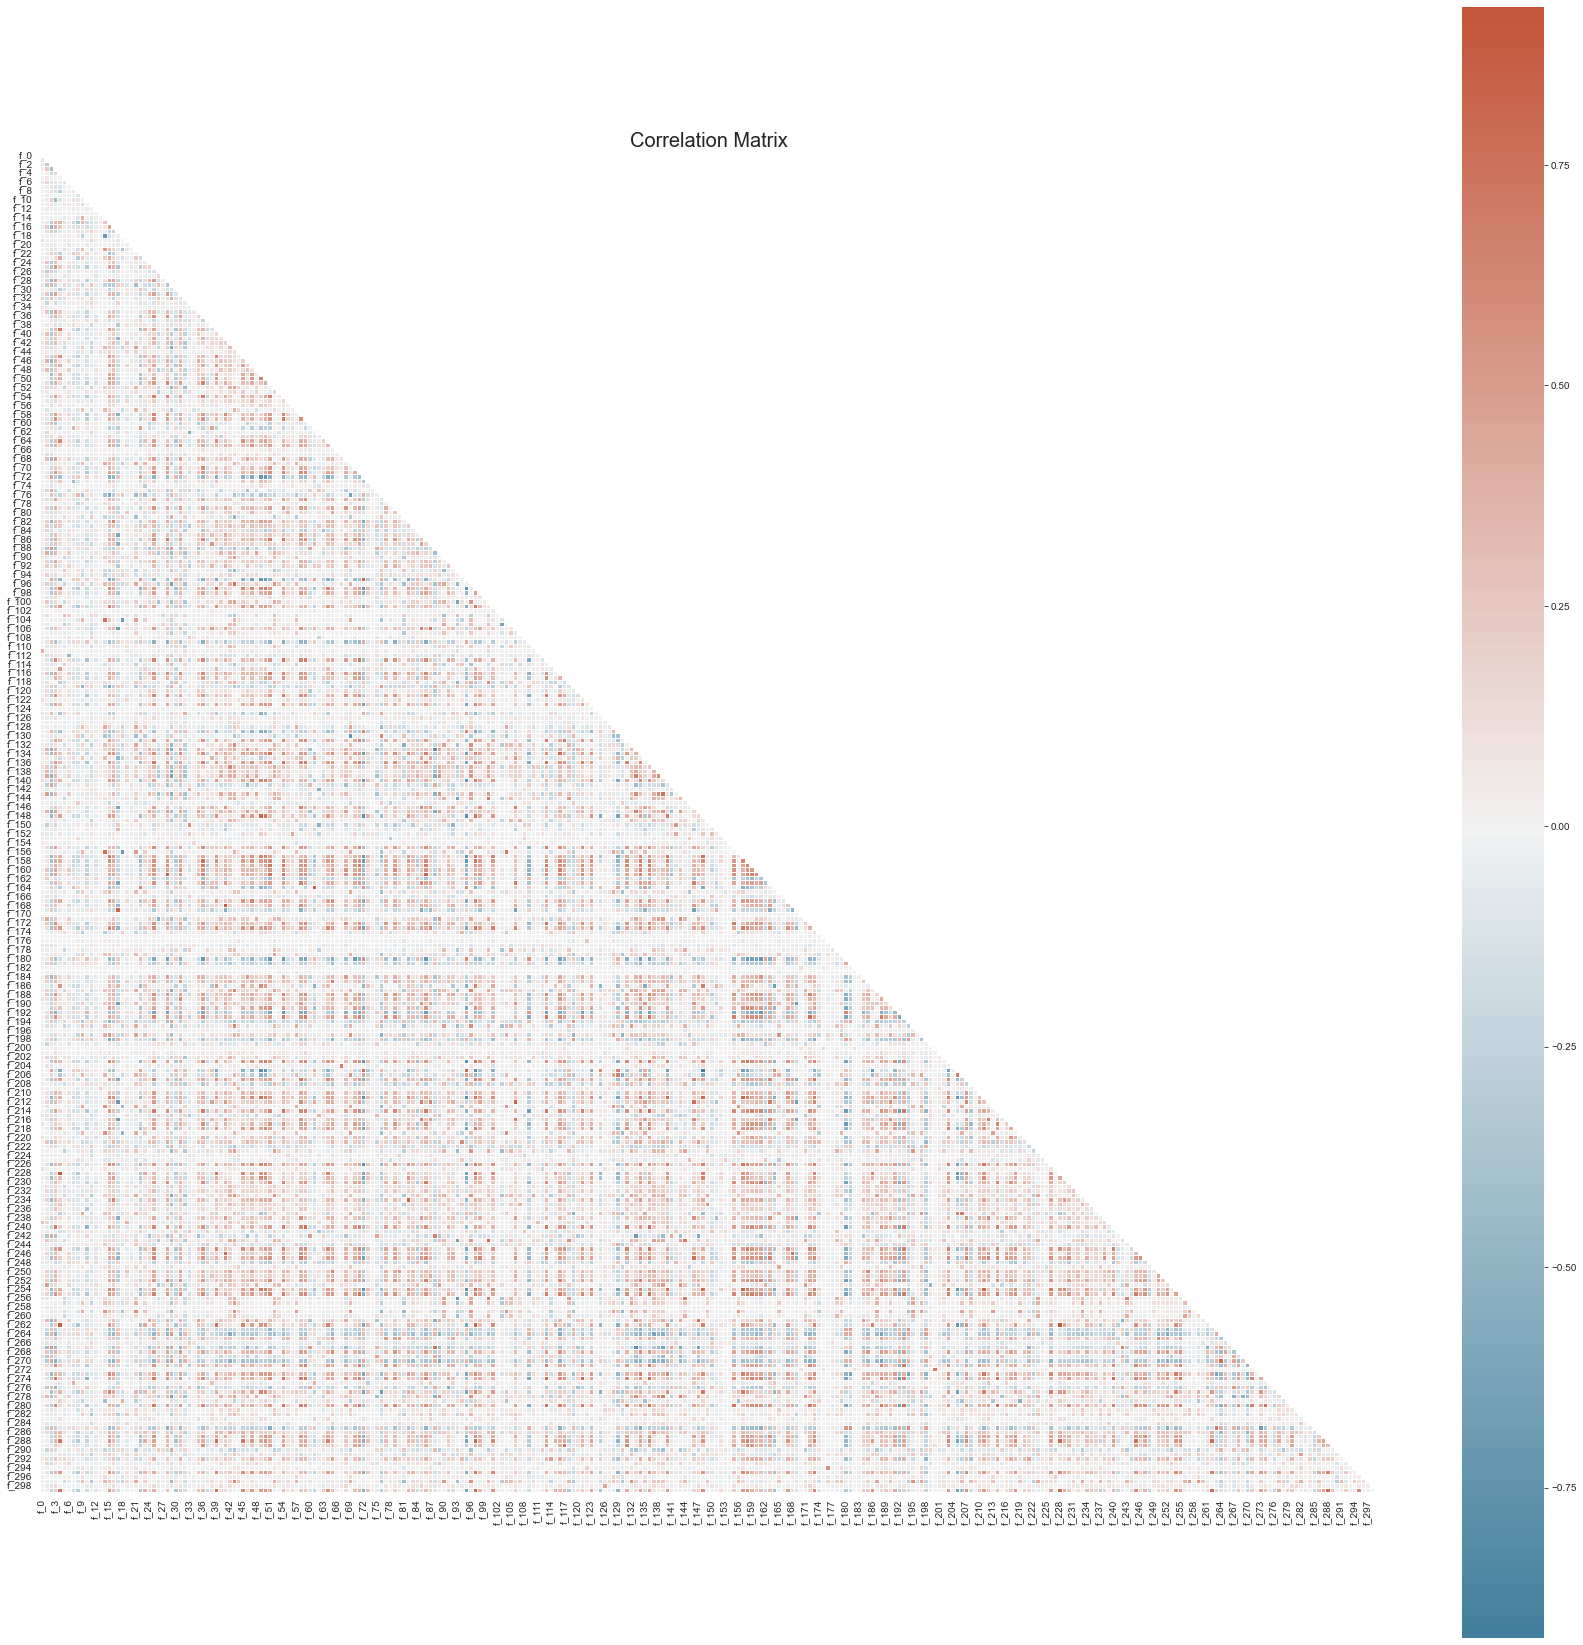

<IPython.core.display.Javascript object>

In [90]:
# Display heatmap
mat_corr(sample_df[features])

Most of correlations are low. 

We are going to see the highest correlations. Generally, it is considered that high correlation is above 0.8.

In [6]:
# Compute correlation matrix with absolute values
corr_matrix = sample_df[features].corr().abs()

# Keep high correlations
high_corr_var = np.where(corr_matrix >= 0.80)

# Get pairs of features with high correlations
high_corr_var = [
    (corr_matrix.columns[x], corr_matrix.columns[y])
    for x, y in zip(*high_corr_var)
    if x != y and x < y
]
high_corr_var

[('f_4', 'f_228'),
 ('f_4', 'f_262'),
 ('f_17', 'f_169'),
 ('f_28', 'f_161'),
 ('f_39', 'f_97'),
 ('f_41', 'f_168'),
 ('f_41', 'f_246'),
 ('f_49', 'f_148'),
 ('f_49', 'f_205'),
 ('f_61', 'f_164'),
 ('f_72', 'f_95'),
 ('f_72', 'f_226'),
 ('f_82', 'f_234'),
 ('f_86', 'f_161'),
 ('f_95', 'f_148'),
 ('f_97', 'f_262'),
 ('f_97', 'f_288'),
 ('f_97', 'f_299'),
 ('f_100', 'f_243'),
 ('f_106', 'f_212'),
 ('f_121', 'f_274'),
 ('f_148', 'f_205'),
 ('f_157', 'f_211'),
 ('f_157', 'f_254'),
 ('f_211', 'f_254'),
 ('f_228', 'f_262'),
 ('f_240', 'f_274')]

<IPython.core.display.Javascript object>

We can see that several features are correlated to more than one feature, such as f_4, f_228, f_41, f_95, f_97...

In [9]:
# Select the lower triangle of the correlation matrix
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))
# k = -1 to remove values on diagonal

<IPython.core.display.Javascript object>

In [93]:
lower

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
f_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_1,0.080340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_2,0.077651,0.308193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_3,0.016761,0.266655,0.402208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_4,0.002498,0.023062,0.190986,0.173860,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f_295,0.008314,0.104512,0.306928,0.369551,0.535145,0.009699,0.002146,0.175664,0.327852,0.077917,...,0.107571,0.118599,0.230016,0.044341,0.030154,NaN,NaN,NaN,NaN,NaN
f_296,0.034092,0.003732,0.003924,0.006542,0.012047,0.028818,0.022453,0.005458,0.022693,0.089613,...,0.187911,0.020867,0.010887,0.004426,0.022381,0.023850,NaN,NaN,NaN,NaN
f_297,0.008676,0.026888,0.034401,0.032219,0.005371,0.192526,0.057937,0.001315,0.114351,0.272527,...,0.317000,0.298905,0.112833,0.001112,0.202802,0.095464,0.103171,NaN,NaN,NaN
f_298,0.003163,0.054242,0.093006,0.155074,0.015210,0.010884,0.003131,0.012641,0.021998,0.009558,...,0.055165,0.025843,0.063290,0.008622,0.001215,0.049705,0.015288,0.030980,NaN,NaN


<IPython.core.display.Javascript object>

In [7]:
# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# k = 1 to remove values on diagonal

<IPython.core.display.Javascript object>

In [95]:
upper

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
f_0,NaN,0.08034,0.077651,0.016761,0.002498,0.008232,0.069825,0.002265,0.015165,0.007302,...,0.025271,0.006614,0.046703,0.009470,0.007777,0.008314,0.034092,0.008676,0.003163,0.025833
f_1,NaN,NaN,0.308193,0.266655,0.023062,0.056259,0.179982,0.033463,0.025831,0.042427,...,0.248299,0.029436,0.124071,0.182843,0.008788,0.104512,0.003732,0.026888,0.054242,0.034509
f_2,NaN,NaN,NaN,0.402208,0.190986,0.000615,0.130356,0.079581,0.122162,0.009768,...,0.194634,0.023163,0.163836,0.158278,0.008086,0.306928,0.003924,0.034401,0.093006,0.268148
f_3,NaN,NaN,NaN,NaN,0.173860,0.005697,0.095658,0.125312,0.155202,0.008483,...,0.173530,0.017960,0.258542,0.085105,0.002998,0.369551,0.006542,0.032219,0.155074,0.229796
f_4,NaN,NaN,NaN,NaN,NaN,0.000482,0.028708,0.114562,0.280519,0.001236,...,0.003259,0.079482,0.087543,0.018189,0.000850,0.535145,0.012047,0.005371,0.015210,0.717434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f_295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.023850,0.095464,0.049705,0.598366
f_296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.103171,0.015288,0.011205
f_297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030980,0.040726
f_298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003108


<IPython.core.display.Javascript object>

In [96]:
# Find features with correlation greater than 0.80 in lower matrix
to_drop_low = [column for column in lower.columns if any(lower[column] >= 0.8)]
print("{} features with high correlation (>=0.8)".format(len(to_drop_low)))

20 features with high correlation (>=0.8)


<IPython.core.display.Javascript object>

In [8]:
# Find features with correlation greater than 0.80 in upper matrix
to_drop_up = [column for column in upper.columns if any(upper[column] >= 0.8)]
print("{} features with high correlation (>=0.8)".format(len(to_drop_up)))

20 features with high correlation (>=0.8)


<IPython.core.display.Javascript object>

In [98]:
# Let's see which features are both in drop lists
feat_common = [f for f in to_drop_low if f in to_drop_up]
feat_common

['f_95', 'f_97', 'f_148', 'f_211', 'f_228']

<IPython.core.display.Javascript object>

There are 5 features in common for the drop lists. Otherwise, 15 features are different considering upper or lower part of the matrix. Maybe this could have an incidence for the modelisation. 

Let's have a look of their distribution.

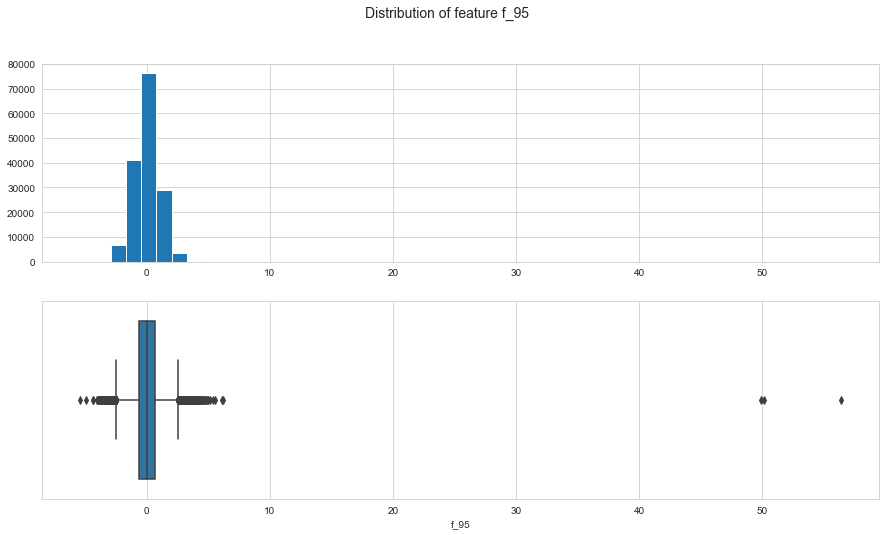

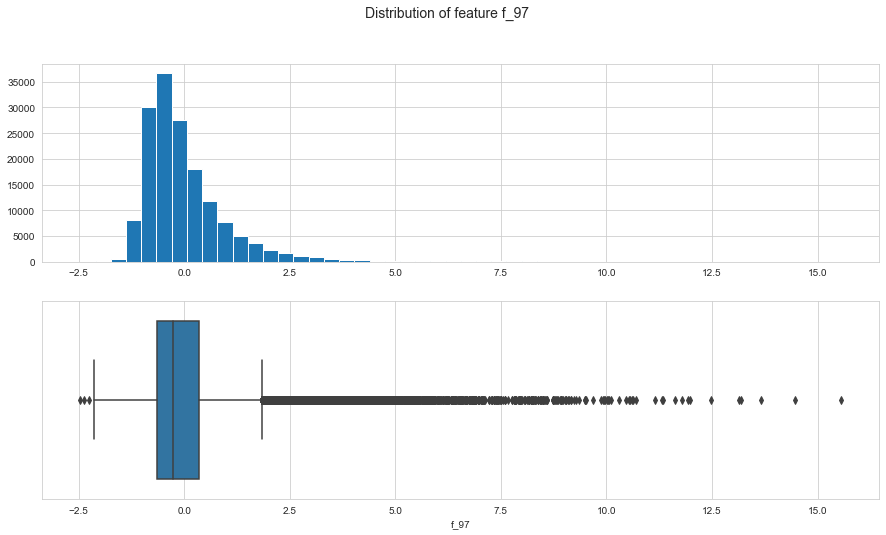

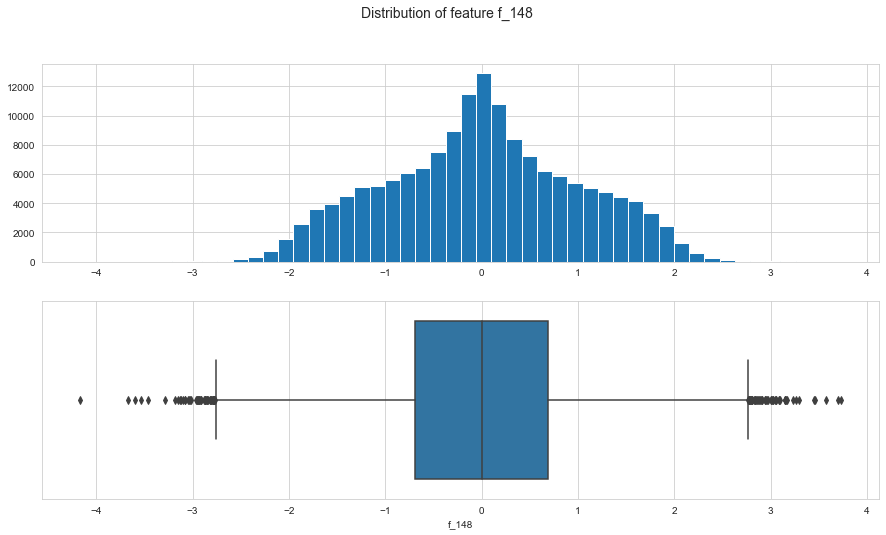

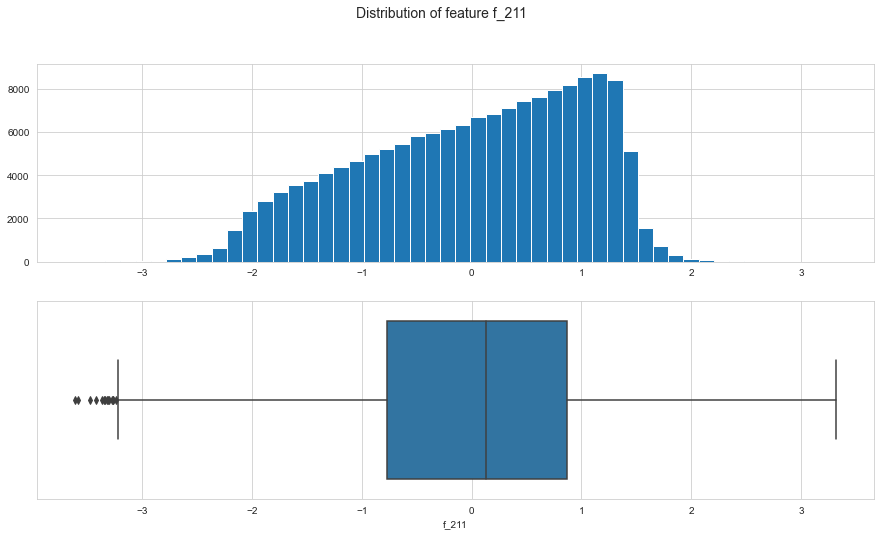

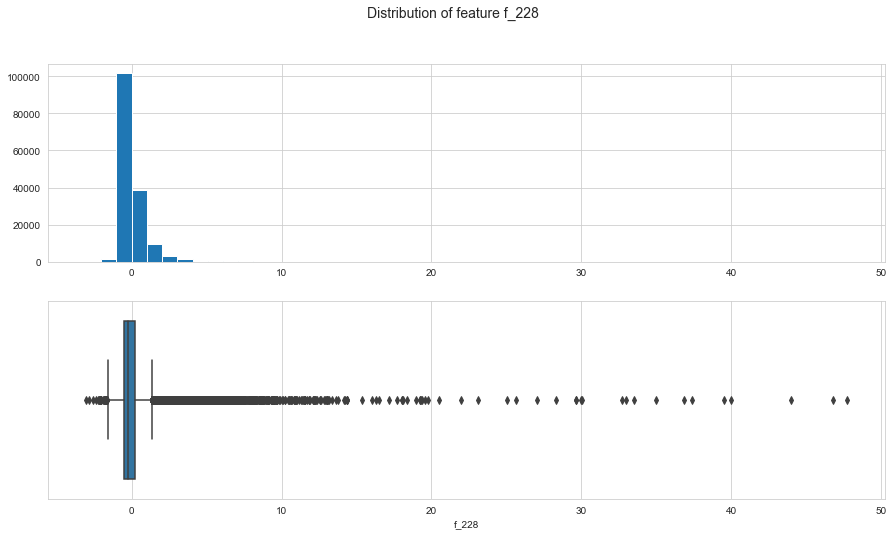

<IPython.core.display.Javascript object>

In [22]:
# Plot histograms and boxplot of these features f_
for f in feat_common:
    
    # Initiate plot
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    plt.suptitle("Distribution of feature {}".format(f), size=14)
    
    # Target histogram
    sample_df["{}".format(f)].hist(bins=50, ax=axes[0])

    # Target Boxplot
    sns.boxplot(x="{}".format(f), data=sample_df, ax=axes[1])
    plt.show()

Distribution are not all centered in zero. Many outliers.

So we are going to compare 2 possibilities : upper matrix and lower matrix.

In [23]:
# Drop these features
sample_df_up = sample_df.drop(to_drop_up, axis=1)
sample_df_low = sample_df.drop(to_drop_low, axis=1)

<IPython.core.display.Javascript object>

In [24]:
print("sample_df_up shape : ", sample_df_up.shape)
print("sample_df_low shape : ", sample_df_low.shape)

sample_df_up shape :  (157070, 284)
sample_df_low shape :  (157070, 284)


<IPython.core.display.Javascript object>

In [25]:
# Remove others columns that are not "features"
others = ["row_id", "time_id", "investment_id", "target"]

features_up = list(sample_df_up.columns)
features_low = list(sample_df_low.columns)

for x in others:
    features_up.remove(x)
    features_low.remove(x)

<IPython.core.display.Javascript object>

In [12]:
len(features_up)

280

<IPython.core.display.Javascript object>

In [27]:
len(features_low)

280

<IPython.core.display.Javascript object>

Correlated features have been removed.

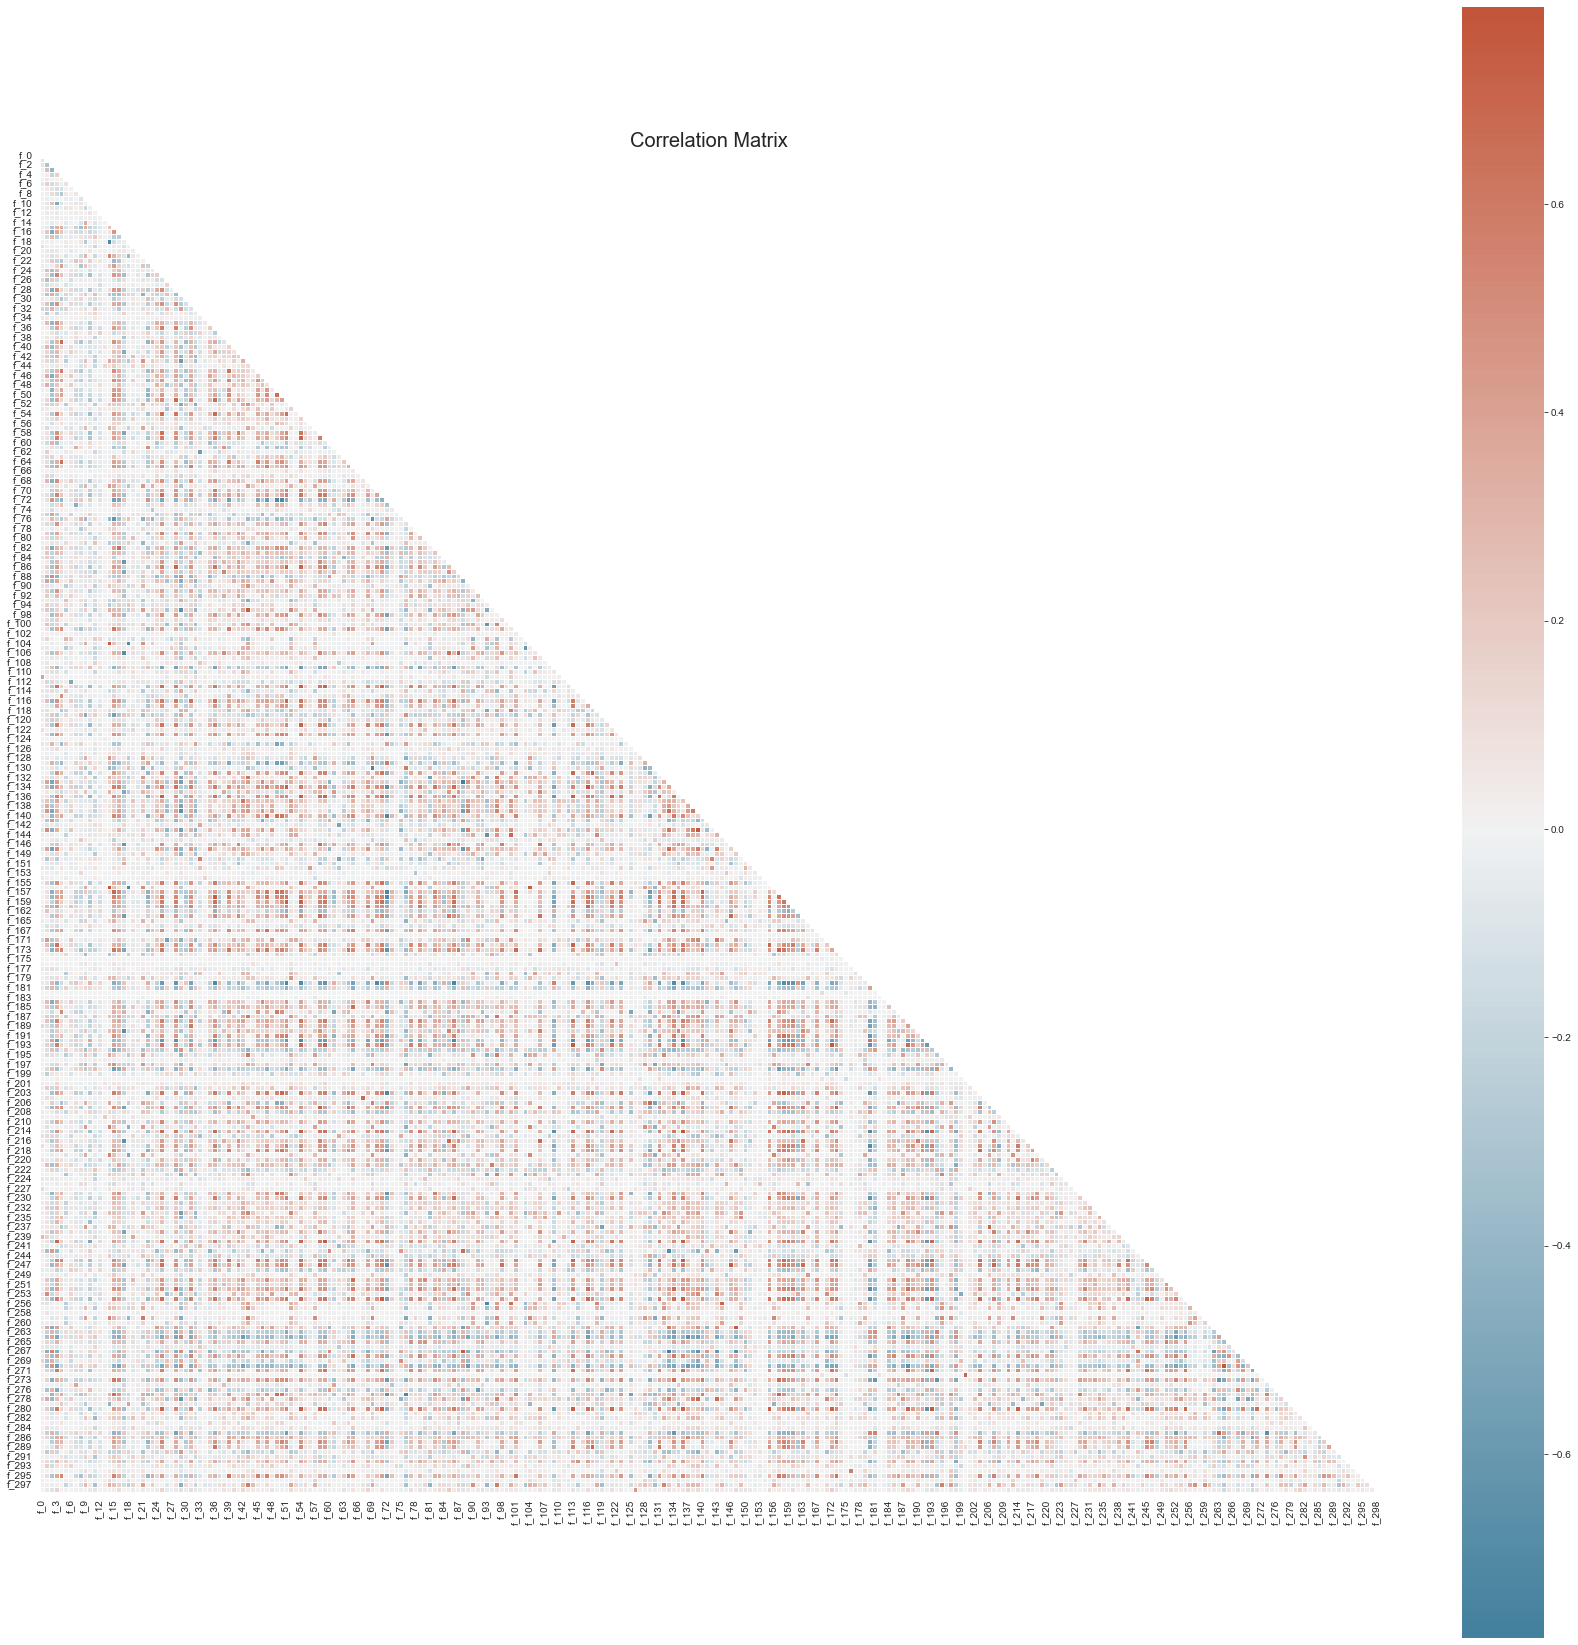

<IPython.core.display.Javascript object>

In [104]:
# Let's have a look at correlation matrix
mat_corr(sample_df[features_up])

It remains some correlation above 0.6 in absolute value.

## Split data
We are going to split data now in order that the test part is not influenced by operations done on the train part.

In [29]:
# Define X and y
X = sample_df[features].values
X_up = sample_df_up.drop(others, axis=1).values
X_low = sample_df_low.drop(others, axis=1).values
y = sample_df_up["target"].values

<IPython.core.display.Javascript object>

In [30]:
print("X shape : ", X.shape)
print("X_up shape : ", X_up.shape)
print("X_low shape : ", X_low.shape)
print("y shape : ", y.shape)

X shape :  (157070, 300)
X_up shape :  (157070, 280)
X_low shape :  (157070, 280)
y shape :  (157070,)


<IPython.core.display.Javascript object>

The test part has to be the end of the dataset as it is "the future" observations (remember that our data are ordered by time_id).

In [31]:
# Split data
X_train = X[:140000]
X_test = X[140000:]

X_up_train = X_up[:140000]
X_up_test = X_up[140000:]

X_low_train = X_low[:140000]
X_low_test = X_low[140000:]

y_train = y[:140000]
y_test = y[140000:]

print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("X_up_train shape : ", X_up_train.shape)
print("X_up_test shape : ", X_up_test.shape)
print("X_low_train shape : ", X_low_train.shape)
print("X_low_test shape : ", X_low_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (140000, 300)
X_test shape :  (17070, 300)
X_up_train shape :  (140000, 280)
X_up_test shape :  (17070, 280)
X_low_train shape :  (140000, 280)
X_low_test shape :  (17070, 280)
y_train shape :  (140000,)
y_test shape :  (17070,)


<IPython.core.display.Javascript object>

In [32]:
perc_test = round(len(X_up_test) / len(X_up) * 100, 1)
print("Percent of data in test set : {}%".format(perc_test))

Percent of data in test set : 10.9%


<IPython.core.display.Javascript object>

In [33]:
# Save data
joblib.dump(X_train, "./Data/X_train.joblib")
joblib.dump(X_test, "./Data/X_test.joblib")
joblib.dump(X_up_train, "./Data/X_up_train.joblib")
joblib.dump(X_low_train, "./Data/X_low_train.joblib")
joblib.dump(X_up_test, "./Data/X_up_test.joblib")
joblib.dump(X_low_test, "./Data/X_low_test.joblib")
joblib.dump(y_train, "./Data/y_train.joblib")
joblib.dump(y_test, "./Data/y_test.joblib")

['./Data/y_test.joblib']

<IPython.core.display.Javascript object>

In [3]:
# Load data
X_train = joblib.load("./Data/X_train.joblib")
X_test = joblib.load("./Data/X_test.joblib")
X_up_train = joblib.load("./Data/X_up_train.joblib")
X_low_train = joblib.load("./Data/X_low_train.joblib")
X_up_test = joblib.load("./Data/X_up_test.joblib")
X_low_test = joblib.load("./Data/X_low_test.joblib")
y_train = joblib.load("./Data/y_train.joblib")
y_test = joblib.load("./Data/y_test.joblib")

<IPython.core.display.Javascript object>

In [111]:
# Let's see information about the first line of testset
sample_df.loc[140000]

row_id           1116_3430
time_id               1116
investment_id         3430
target            0.038822
f_0               0.500455
                   ...    
f_295            -0.315079
f_296              1.76854
f_297            -0.767893
f_298            -1.684648
f_299            -0.147932
Name: 140000, Length: 304, dtype: object

<IPython.core.display.Javascript object>

Test set contains data with time_id above 1116.

In [112]:
sample_df.loc[139999]

row_id           1116_3411
time_id               1116
investment_id         3411
target           -0.509043
f_0               0.243152
                   ...    
f_295             0.433784
f_296             0.698854
f_297            -0.566678
f_298             1.151607
f_299             0.062957
Name: 139999, Length: 304, dtype: object

<IPython.core.display.Javascript object>

In [113]:
sample_df.loc[140001]

row_id           1116_3482
time_id               1116
investment_id         3482
target           -1.803552
f_0               0.908216
                   ...    
f_295             -0.54032
f_296             0.389126
f_297             1.701206
f_298             1.556026
f_299            -0.269335
Name: 140001, Length: 304, dtype: object

<IPython.core.display.Javascript object>

## PCA
We are going to consider PCA in order to decrease the number of features.

We are going to compare normalized data and unnormalized data. As mentioned above, we are going to use Robust Scaler for normalization.

### Scale

In [4]:
# X
robust_scal = RobustScaler().fit(X_train)
X_scaled = robust_scal.transform(X_train)
X_scaled.shape

(140000, 300)

<IPython.core.display.Javascript object>

In [4]:
# Up
robust_scal_up = RobustScaler().fit(X_up_train)
X_up_scaled = robust_scal_up.transform(X_up_train)
X_up_scaled.shape

(140000, 280)

<IPython.core.display.Javascript object>

In [5]:
# Low
robust_scal_low = RobustScaler().fit(X_low_train)
X_low_scaled = robust_scal_low.transform(X_low_train)
X_low_scaled.shape

(140000, 280)

<IPython.core.display.Javascript object>

### PCA

In [37]:
# PCA X
pca = PCA(random_state=0)
pca.fit(X_train)

PCA(random_state=0)

<IPython.core.display.Javascript object>

In [6]:
def display_scree_plot(pca, data):

    """ Function to display eigenvalues scree of pca
        
    - Arguments :
        - pca : pca model fitted
        - data : data on which PCA has been fitted (string)
    
    - Display :
        - barplot for each pca component
        - cumulated inertie percent (variance explained by pca) 
    """
    
    # Initiate plot
    plt.figure(figsize=(12, 8))
    
    # Get explained_variance_ratio_
    scree = pca.explained_variance_ratio_ * 100

    # Barplot for each component
    plt.bar(np.arange(len(scree)) + 1, scree)

    # Cumulative sum
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker="o")

    plt.xlabel("rank of the axis of inertia", size=13)
    plt.ylabel("Inertie percent", size=13)
    plt.title("Eigenvalues scree of pca for {}".format(data), size=14)
    plt.show(block=False)

<IPython.core.display.Javascript object>

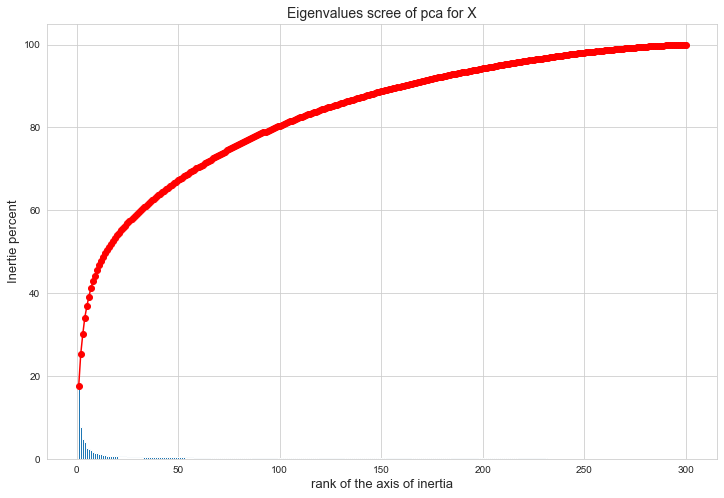

<IPython.core.display.Javascript object>

In [39]:
data = "X"
display_scree_plot(pca, data)

In [4]:
# PCA 0.85 X
pca_85 = PCA(n_components=0.85, random_state=0)
pca_85.fit(X_train)
X_pca85 = pca_85.transform(X_train)
X_pca85.shape

(140000, 125)

<IPython.core.display.Javascript object>

The features number decreases of 58%.

In [43]:
# PCA X_up
pca_up = PCA(random_state=0)
pca_up.fit(X_up_train)

PCA(random_state=0)

<IPython.core.display.Javascript object>

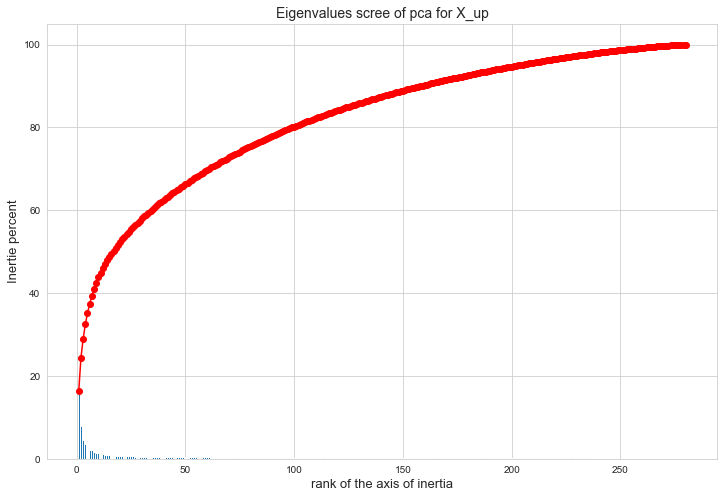

<IPython.core.display.Javascript object>

In [44]:
data = "X_up"
display_scree_plot(pca_up, data)

Let's keep 85% of explained variance.

In [7]:
# PCA 0.85 X_up
pca_up_85 = PCA(n_components=0.85, random_state=0)
pca_up_85.fit(X_up_train)
X_up_pca85 = pca_up_85.transform(X_up_train)
X_up_pca85.shape

(140000, 126)

<IPython.core.display.Javascript object>

The features number decreases of 55%.

In [46]:
nb_comp_up_85 = np.where(pca_up_85.explained_variance_ratio_.cumsum() >= 0.85)[0][0] + 1
nb_comp_up_85

126

<IPython.core.display.Javascript object>

In [47]:
# PCA X_low
pca_low = PCA(random_state=0)
pca_low.fit(X_low_train)

PCA(random_state=0)

<IPython.core.display.Javascript object>

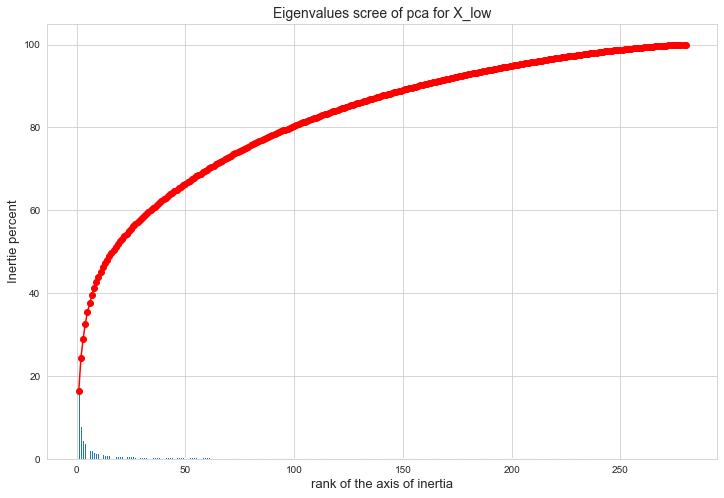

<IPython.core.display.Javascript object>

In [48]:
data = "X_low"
display_scree_plot(pca_low, data)

In [8]:
# PCA 0.85 X_low
pca_low_85 = PCA(n_components=0.85, random_state=0)
pca_low_85.fit(X_low_train)
X_low_pca85 = pca_low_85.transform(X_low_train)
X_low_pca85.shape

(140000, 125)

<IPython.core.display.Javascript object>

The features number decreases of 55.4%.

In [50]:
# PCA X_scaled
pca_scal = PCA(random_state=0)
pca_scal.fit(X_scaled)

PCA(random_state=0)

<IPython.core.display.Javascript object>

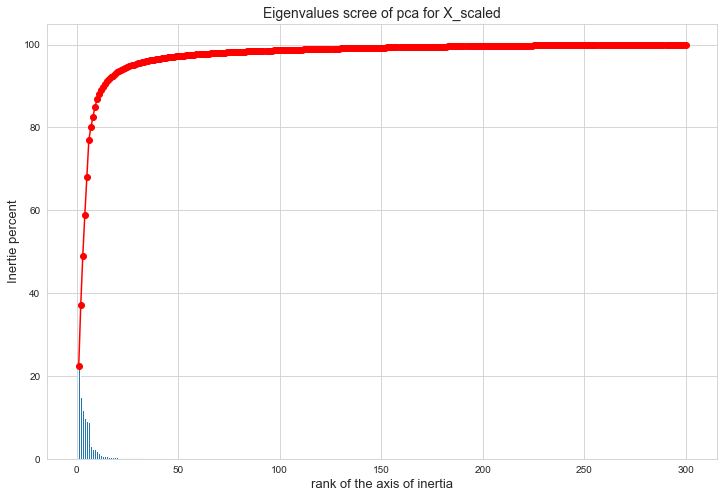

<IPython.core.display.Javascript object>

In [51]:
data = "X_scaled"
display_scree_plot(pca_scal, data)

In [10]:
# PCA 0.85 X_scaled
pca_scal_85 = PCA(n_components=0.85, random_state=0)
pca_scal_85.fit(X_scaled)
X_scal_pca85 = pca_scal_85.transform(X_scaled)
X_scal_pca85.shape

(140000, 10)

<IPython.core.display.Javascript object>

The features number decreases of 96.7% !

In [53]:
# PCA X_up_scaled
pca_up_scal = PCA(random_state=0)
pca_up_scal.fit(X_up_scaled)

PCA(random_state=0)

<IPython.core.display.Javascript object>

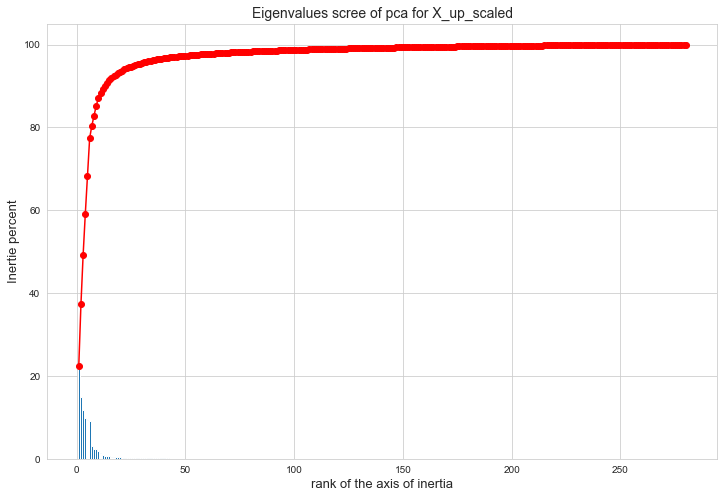

<IPython.core.display.Javascript object>

In [54]:
data = "X_up_scaled"
display_scree_plot(pca_up_scal, data)

In [10]:
# PCA 0.85 X_up_scaled
pca_up_scal_85 = PCA(n_components=0.85, random_state=0)
pca_up_scal_85.fit(X_up_scaled)
X_up_scal_pca85 = pca_up_scal_85.transform(X_up_scaled)
X_up_scal_pca85.shape

(140000, 9)

<IPython.core.display.Javascript object>

The features number decreases of 96.8% !

In [57]:
# PCA X_low_scaled
pca_low_scal = PCA(random_state=0)
pca_low_scal.fit(X_low_scaled)

PCA(random_state=0)

<IPython.core.display.Javascript object>

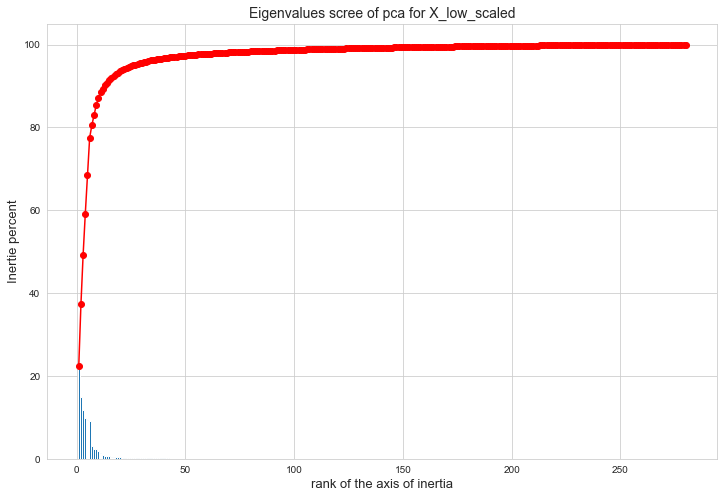

<IPython.core.display.Javascript object>

In [58]:
data = "X_low_scaled"
display_scree_plot(pca_low_scal, data)

In [11]:
# PCA 0.85 X_low_scaled
pca_low_scal_85 = PCA(n_components=0.85, random_state=0)
pca_low_scal_85.fit(X_low_scaled)
X_low_scal_pca85 = pca_low_scal_85.transform(X_low_scaled)
X_low_scal_pca85.shape

(140000, 9)

<IPython.core.display.Javascript object>

The features number decreases of 96.8% !

## Conclusion

The fact that time_id is not constant and that investment_id are not present for each time_id lead to difficult approaches for modelisation. 

Therefore, we are going to consider only the features f_i in our modelisations. Regarding the work done on PCA, scaling and correlation, we are going to compare these different data for modelisation.